<a href="https://colab.research.google.com/github/Aravindh4404/Trading_Bot/blob/main/DIATRY7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing A.csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0093 - val_loss: 9.4354e-04
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 8.5946e-04 - val_loss: 0.0020
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 7.0804e-04 - val_loss: 0.0018
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 7.5188e-04 - val_loss: 3.0270e-04
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 7.0186e-04 - val_loss: 0.0018
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 5.3634e-04 - val_loss: 6.1510e-04
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 4.9214e-04 - val_loss: 0.0020
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 6.2318e-04 - val_loss: 0.0021
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 5.0181e-04 - val_loss: 3.3414e-04
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 4.6493e-04 - val_loss: 2.1741e-04
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 5.4056e

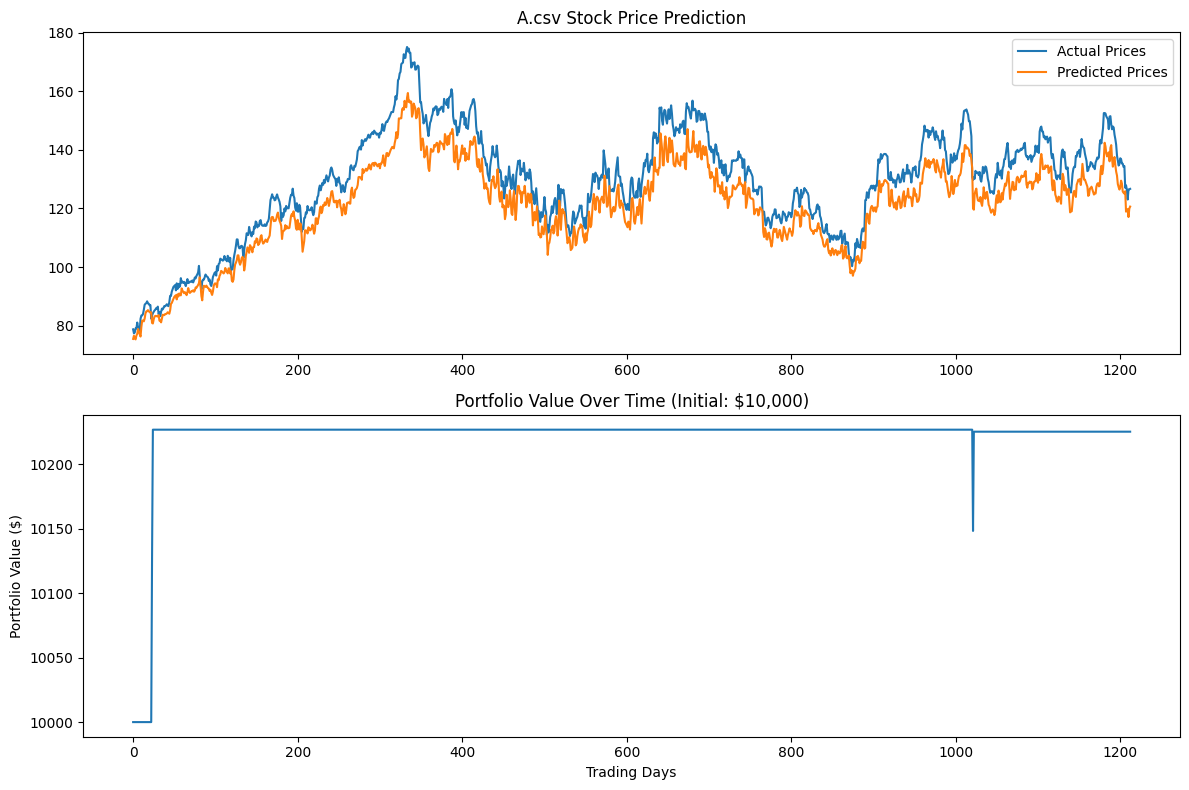

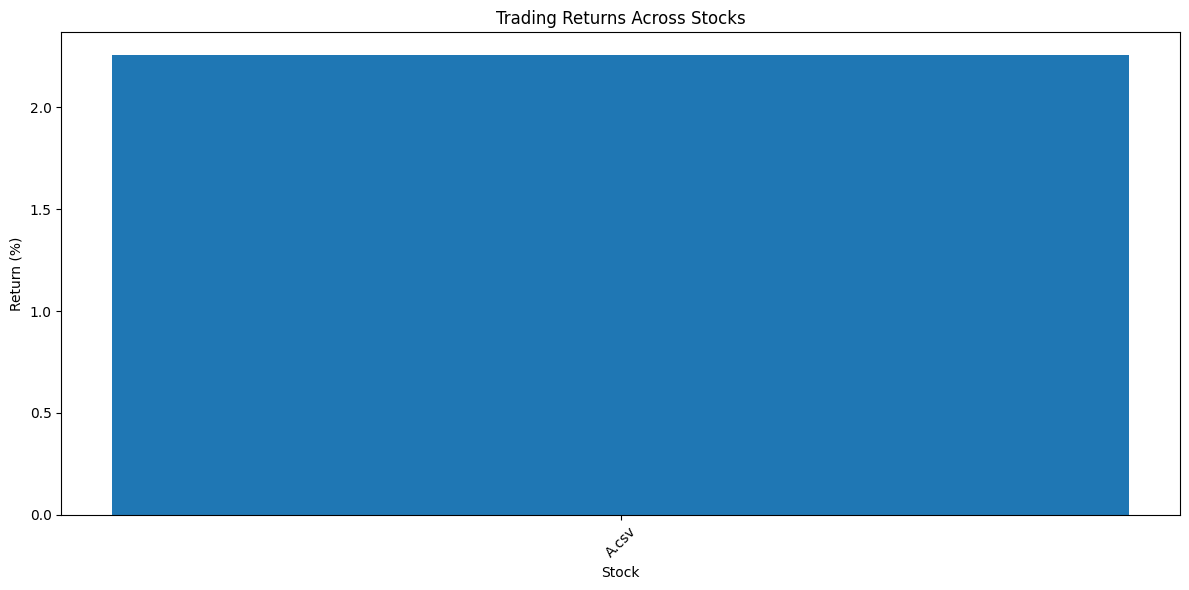

In [ ]:
  import os
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import MinMaxScaler
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import LSTM, Dense, Dropout
  import re

  # Define paths
  base_path = '/content/drive/My Drive/DIA TEST/'
  train_path = os.path.join(base_path, 'training')
  validation_path = os.path.join(base_path, 'validation')
  test_path = os.path.join(base_path, 'testing')

  def load_data(file_path):
      """Load stock data properly handling the CSV file format with metadata headers."""
      # Read the file with no specific header to examine structure
      with open(file_path, 'r') as f:
          lines = f.readlines()

      # Find where the actual data starts (after the 'Date' row)
      data_start = 0
      for i, line in enumerate(lines):
          if line.strip().startswith('Date'):
              data_start = i + 1
              break

      # Read the CSV file again, now skipping metadata rows
      df = pd.read_csv(file_path, skiprows=data_start, header=None)

      # Name the columns appropriately
      columns = ['Date']
      for i in range(1, df.shape[1]):
          columns.append(f'Value{i}')
      df.columns = columns

      # Convert Date to datetime
      df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

      # Use the second column as Close price
      df['Close'] = pd.to_numeric(df['Value1'], errors='coerce')

      # Filter out rows with invalid data
      df = df[~df['Date'].isna() & ~df['Close'].isna()].reset_index(drop=True)

      # Sort by date
      df = df.sort_values('Date')

      return df

  def prepare_data(df, scaler=None, look_back=60):
      """Prepare time series data for LSTM model."""
      if scaler is None:
          scaler = MinMaxScaler(feature_range=(0, 1))
          scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
      else:
          scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

      X, y = [], []
      for i in range(look_back, len(scaled_data)):
          X.append(scaled_data[i-look_back:i, 0])
          y.append(scaled_data[i, 0])

      X, y = np.array(X), np.array(y)
      X = np.reshape(X, (X.shape[0], X.shape[1], 1))

      return X, y, scaler

  def create_model(look_back):
      """Create a simple LSTM model for time series prediction."""
      model = Sequential([
          LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)),
          Dropout(0.2),
          LSTM(units=50, return_sequences=False),
          Dropout(0.2),
          Dense(units=1)
      ])
      model.compile(optimizer='adam', loss='mean_squared_error')
      return model

  def evaluate_model(model, test_df, actual_prices, predicted_prices):
      """Evaluate model performance and calculate trading returns."""
      # Calculate RMSE
      rmse = np.sqrt(np.mean((actual_prices - predicted_prices)**2))

      # Simulate trading based on predictions
      initial_capital = 10000
      position = 0
      portfolio_value = [initial_capital]

      for i in range(1, len(predicted_prices)):
          # Strategy: Buy if predicted price is higher than current price
          current_price = actual_prices[i-1][0]
          next_price = actual_prices[i][0]
          predicted_next = predicted_prices[i-1][0]

          if predicted_next > current_price * 1.01 and position == 0:
              # Buy
              position = portfolio_value[-1] / current_price
              portfolio_value.append(position * next_price)
          elif predicted_next < current_price * 0.99 and position > 0:
              # Sell
              portfolio_value.append(position * next_price)
              position = 0
          else:
              # Hold
              if position > 0:
                  portfolio_value.append(position * next_price)
              else:
                  portfolio_value.append(portfolio_value[-1])

      # Calculate returns
      total_return = (portfolio_value[-1] - initial_capital) / initial_capital * 100

      return {
          'rmse': rmse,
          'total_return': total_return,
          'portfolio_values': portfolio_value
      }

  def process_stock(stock_file):
      """Process a single stock file - train, validate and test the model."""
      try:
          print(f"Processing {stock_file}")

          # Load data
          train_df = load_data(os.path.join(train_path, stock_file))
          val_df = load_data(os.path.join(validation_path, stock_file))
          test_df = load_data(os.path.join(test_path, stock_file))

          # Set parameters
          look_back = 60

          # Prepare data
          X_train, y_train, scaler = prepare_data(train_df, look_back=look_back)
          X_val, y_val, _ = prepare_data(val_df, scaler=scaler, look_back=look_back)
          X_test, y_test, _ = prepare_data(test_df, scaler=scaler, look_back=look_back)

          # Create and train model
          model = create_model(look_back)
          history = model.fit(
              X_train, y_train,
              epochs=50,
              batch_size=32,
              validation_data=(X_val, y_val),
              verbose=1
          )

          # Make predictions
          test_predictions = model.predict(X_test)
          test_predictions = scaler.inverse_transform(test_predictions)
          y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

          # Evaluate performance
          results = evaluate_model(model, test_df, y_test_inv, test_predictions)

          print(f"RMSE for {stock_file}: {results['rmse']:.4f}")
          print(f"Trading Return: {results['total_return']:.2f}%")

          # Plot results
          plt.figure(figsize=(12, 8))

          # Plot 1: Actual vs Predicted Prices
          plt.subplot(2, 1, 1)
          plt.plot(y_test_inv, label='Actual Prices')
          plt.plot(test_predictions, label='Predicted Prices')
          plt.title(f'{stock_file} Stock Price Prediction')
          plt.legend()

          # Plot 2: Portfolio Value
          plt.subplot(2, 1, 2)
          plt.plot(results['portfolio_values'])
          plt.title(f'Portfolio Value Over Time (Initial: $10,000)')
          plt.xlabel('Trading Days')
          plt.ylabel('Portfolio Value ($)')

          plt.tight_layout()
          plt.show()

          return model, results

      except Exception as e:
          print(f"Error processing {stock_file}: {str(e)}")
          return None, None

  # Process all stock files
  def process_all_stocks():
      results = {}
      for stock_file in os.listdir(train_path):
          if stock_file.endswith('.csv'):
              if os.path.exists(os.path.join(validation_path, stock_file)) and os.path.exists(os.path.join(test_path, stock_file)):
                  model, eval_results = process_stock(stock_file)
                  if model is not None:
                      results[stock_file] = eval_results
              else:
                  print(f"Skipping {stock_file} as it's not present in all folders")

      # Compare performance across stocks
      if results:
          stocks = list(results.keys())
          returns = [results[s]['total_return'] for s in stocks]

          plt.figure(figsize=(12, 6))
          plt.bar(stocks, returns)
          plt.title('Trading Returns Across Stocks')
          plt.xlabel('Stock')
          plt.ylabel('Return (%)')
          plt.xticks(rotation=45)
          plt.tight_layout()
          plt.show()

  # Run the processing
  process_all_stocks()


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
import datetime

# Add these debugging functions

def verify_data_separation(train_df, val_df, test_df):
    """Verify proper separation of training, validation, and test data."""
    print("\n=== DATA SEPARATION VERIFICATION ===")
    print(f"Training data range: {train_df['Date'].min()} to {train_df['Date'].max()}")
    print(f"Validation data range: {val_df['Date'].min()} to {val_df['Date'].max()}")
    print(f"Testing data range: {test_df['Date'].min()} to {test_df['Date'].max()}")

    # Check for date overlap
    train_dates = set(train_df['Date'])
    val_dates = set(val_df['Date'])
    test_dates = set(test_df['Date'])

    train_val_overlap = train_dates.intersection(val_dates)
    train_test_overlap = train_dates.intersection(test_dates)
    val_test_overlap = val_dates.intersection(test_dates)

    if train_val_overlap or train_test_overlap or val_test_overlap:
        print("\n⚠️ WARNING: Date overlap detected between datasets!")
        print(f"Train-Validation overlap: {len(train_val_overlap)} dates")
        print(f"Train-Test overlap: {len(train_test_overlap)} dates")
        print(f"Validation-Test overlap: {len(val_test_overlap)} dates")
    else:
        print("\n✅ No date overlap detected between datasets.")

    # Verify chronological order
    if train_df['Date'].max() < val_df['Date'].min() and val_df['Date'].max() < test_df['Date'].min():
        print("✅ Datasets are in proper chronological order (Train → Validation → Test)")
    else:
        print("⚠️ WARNING: Datasets are not in proper chronological order!")

def visualize_prediction_errors(y_true, y_pred, title='Prediction Error Analysis'):
    """Visualize errors between predictions and actual values."""
    errors = y_true - y_pred

    plt.figure(figsize=(15, 10))

    # Error over time
    plt.subplot(2, 2, 1)
    plt.plot(errors, color='red')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')

    # Histogram of errors
    plt.subplot(2, 2, 2)
    plt.hist(errors, bins=50, color='blue', alpha=0.7)
    plt.title('Error Distribution')
    plt.xlabel('Error Value')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--')

    # Scatter plot of actual vs predicted
    plt.subplot(2, 2, 3)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Percentage error
    plt.subplot(2, 2, 4)
    pct_errors = (errors / y_true) * 100
    plt.plot(pct_errors, color='purple')
    plt.title('Percentage Error Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Percentage Error (%)')
    plt.axhline(y=0, color='grey', linestyle='--')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print error statistics
    print("\n=== PREDICTION ERROR STATISTICS ===")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Mean Absolute Error: {np.mean(np.abs(errors)):.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(np.mean(np.square(errors))):.4f}")
    print(f"Mean Percentage Error: {np.mean(pct_errors):.4f}%")
    print(f"Mean Absolute Percentage Error: {np.mean(np.abs(pct_errors)):.4f}%")

def forecast_multiple_steps(model, initial_sequence, steps, scaler, look_back):
    """Test multi-step forecasting to see prediction accuracy degradation."""
    # Save original sequence for reference
    original_sequence = initial_sequence.copy()

    # Create current sequence for iterative prediction
    current_sequence = original_sequence[-look_back:].reshape(1, look_back, 1)

    # Store all predictions
    forecasted_values = []

    for step in range(steps):
        # Make prediction for next step
        next_pred = model.predict(current_sequence, verbose=0)[0][0]
        forecasted_values.append(next_pred)

        # Update sequence for next prediction (remove oldest, add new prediction)
        new_sequence = np.append(current_sequence.reshape(-1), next_pred)
        current_sequence = new_sequence[-look_back:].reshape(1, look_back, 1)

    # Convert back to original scale
    forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

    return forecasted_values

def test_multi_step_forecast(model, test_data, scaler, look_back, forecast_windows=[1, 5, 10, 20]):
    """Test and visualize multi-step forecasting with different windows."""
    # Select several starting points from test data
    num_test_points = min(5, len(test_data) // (max(forecast_windows) * 2))
    test_indices = np.linspace(look_back, len(test_data) - max(forecast_windows) - 1, num_test_points, dtype=int)

    plt.figure(figsize=(15, num_test_points*4))
    plt.suptitle(f'Multi-step Forecasting Evaluation', fontsize=16)

    for i, idx in enumerate(test_indices):
        actual_sequence = test_data[:idx]
        future_actual = scaler.inverse_transform(test_data[idx:idx+max(forecast_windows)].reshape(-1, 1))

        plt.subplot(num_test_points, 1, i+1)

        # Plot actual values
        days = np.arange(-look_back, max(forecast_windows))
        historical = scaler.inverse_transform(test_data[idx-look_back:idx+max(forecast_windows)].reshape(-1, 1))
        plt.plot(days, historical, 'b-', label='Actual Prices')

        # Plot forecasts of different lengths
        colors = ['r-', 'g-', 'm-', 'y-']
        for j, window in enumerate(forecast_windows):
            forecast = forecast_multiple_steps(model, actual_sequence, window, scaler, look_back)
            plt.plot(np.arange(0, window), forecast, colors[j], label=f'{window}-step Forecast')

            # Calculate error metrics for this forecast
            actual_subset = future_actual[:window]
            mape = np.mean(np.abs((actual_subset - forecast) / actual_subset)) * 100
            rmse = np.sqrt(np.mean(np.square(actual_subset - forecast)))
            plt.text(window-1, forecast[-1][0], f'{mape:.1f}%', color=colors[j][0])

        plt.axvline(x=0, color='k', linestyle='--')
        plt.title(f'Test Point {i+1}: Multi-step Forecast vs Actual')
        plt.xlabel('Days (Negative = Historical, Positive = Future)')
        plt.ylabel('Stock Price')
        plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

class DetailedMetricsCallback(Callback):
    """Custom callback to record detailed metrics during training."""
    def __init__(self, validation_data, scaler, look_back, log_dir=None):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.scaler = scaler
        self.look_back = look_back
        self.train_losses = []
        self.val_losses = []
        self.val_mapes = []
        self.val_rmses = []
        self.best_val_loss = float('inf')
        self.epochs_no_improve = 0
        self.log_dir = log_dir

        # Create log directory if specified
        if log_dir and not os.path.exists(log_dir):
            os.makedirs(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # Calculate additional metrics on validation data
        val_pred = self.model.predict(self.X_val, verbose=0)
        val_pred_inv = self.scaler.inverse_transform(val_pred)
        val_true_inv = self.scaler.inverse_transform(self.y_val.reshape(-1, 1))

        # Calculate MAPE and RMSE
        mape = np.mean(np.abs((val_true_inv - val_pred_inv) / val_true_inv)) * 100
        rmse = np.sqrt(np.mean(np.square(val_true_inv - val_pred_inv)))

        self.val_mapes.append(mape)
        self.val_rmses.append(rmse)

        # Print detailed metrics every 5 epochs
        if epoch % 5 == 0 or epoch == 0:
            print(f"\nEpoch {epoch+1} - val_loss: {logs['val_loss']:.4f}, val_mape: {mape:.2f}%, val_rmse: {rmse:.4f}")

        # Save detailed metrics if log_dir is specified
        if self.log_dir:
            with open(os.path.join(self.log_dir, 'training_log.txt'), 'a') as f:
                f.write(f"Epoch {epoch+1}: train_loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}, val_mape={mape:.2f}%, val_rmse={rmse:.4f}\n")

            # Save model checkpoints
            if logs['val_loss'] < self.best_val_loss:
                self.best_val_loss = logs['val_loss']
                self.epochs_no_improve = 0
                self.model.save(os.path.join(self.log_dir, 'best_model.h5'))
            else:
                self.epochs_no_improve += 1

    def plot_metrics(self):
        """Plot training metrics."""
        plt.figure(figsize=(15, 10))

        # Plot training and validation loss
        plt.subplot(2, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend()

        # Plot validation MAPE
        plt.subplot(2, 2, 2)
        plt.plot(self.val_mapes, color='green')
        plt.title('Validation MAPE')
        plt.xlabel('Epochs')
        plt.ylabel('MAPE (%)')

        # Plot validation RMSE
        plt.subplot(2, 2, 3)
        plt.plot(self.val_rmses, color='red')
        plt.title('Validation RMSE')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')

        # Plot validation metrics together (normalized)
        plt.subplot(2, 2, 4)
        # Normalize metrics for comparison
        norm_val_loss = (self.val_losses - np.min(self.val_losses)) / (np.max(self.val_losses) - np.min(self.val_losses))
        norm_val_mape = (self.val_mapes - np.min(self.val_mapes)) / (np.max(self.val_mapes) - np.min(self.val_mapes))
        norm_val_rmse = (self.val_rmses - np.min(self.val_rmses)) / (np.max(self.val_rmses) - np.min(self.val_rmses))

        plt.plot(norm_val_loss, label='Normalized Val Loss')
        plt.plot(norm_val_mape, label='Normalized Val MAPE')
        plt.plot(norm_val_rmse, label='Normalized Val RMSE')
        plt.title('Normalized Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Normalized Value')
        plt.legend()

        plt.tight_layout()
        plt.show()

def debug_process_stock(stock_file, base_path, train_path, validation_path, test_path):
    """Process a single stock file with enhanced debugging."""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join(base_path, 'debug_logs', f"{stock_file.split('.')[0]}_{timestamp}")

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    try:
        print(f"Processing {stock_file} with debugging")

        # Load data
        train_df = load_data(os.path.join(train_path, stock_file))
        val_df = load_data(os.path.join(validation_path, stock_file))
        test_df = load_data(os.path.join(test_path, stock_file))

        # Verify data separation
        verify_data_separation(train_df, val_df, test_df)

        # Set parameters
        look_back = 60

        # Prepare data
        X_train, y_train, scaler = prepare_data(train_df, look_back=look_back)
        X_val, y_val, _ = prepare_data(val_df, scaler=scaler, look_back=look_back)
        X_test, y_test, _ = prepare_data(test_df, scaler=scaler, look_back=look_back)

        # Create and train model with detailed metrics
        model = create_model(look_back)
        metrics_callback = DetailedMetricsCallback(
            validation_data=(X_val, y_val),
            scaler=scaler,
            look_back=look_back,
            log_dir=log_dir
        )

        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[metrics_callback],
            verbose=1
        )

        # Plot training metrics
        metrics_callback.plot_metrics()

        # Make predictions
        test_predictions = model.predict(X_test)
        test_predictions = scaler.inverse_transform(test_predictions)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Visualize prediction errors
        visualize_prediction_errors(y_test_inv, test_predictions, title=f'{stock_file} Prediction Error Analysis')

        # Test multi-step forecasting
        print("\n=== MULTI-STEP FORECASTING TEST ===")
        test_multi_step_forecast(model, np.vstack([X_test[0].reshape(-1), y_test]), scaler, look_back)

        # Evaluate performance
        results = evaluate_model(model, test_df, y_test_inv, test_predictions)

        print(f"RMSE for {stock_file}: {results['rmse']:.4f}")
        print(f"Trading Return: {results['total_return']:.2f}%")

        # Plot original results
        plt.figure(figsize=(12, 8))

        # Plot 1: Actual vs Predicted Prices
        plt.subplot(2, 1, 1)
        plt.plot(y_test_inv, label='Actual Prices')
        plt.plot(test_predictions, label='Predicted Prices')
        plt.title(f'{stock_file} Stock Price Prediction')
        plt.legend()

        # Plot 2: Portfolio Value
        plt.subplot(2, 1, 2)
        plt.plot(results['portfolio_values'])
        plt.title(f'Portfolio Value Over Time (Initial: $10,000)')
        plt.xlabel('Trading Days')
        plt.ylabel('Portfolio Value ($)')

        plt.tight_layout()
        plt.savefig(os.path.join(log_dir, 'results.png'))
        plt.show()

        # Save key results to a summary file
        with open(os.path.join(log_dir, 'summary.txt'), 'w') as f:
            f.write(f"Stock: {stock_file}\n")
            f.write(f"RMSE: {results['rmse']:.4f}\n")
            f.write(f"Trading Return: {results['total_return']:.2f}%\n")
            f.write(f"Final Portfolio Value: ${results['portfolio_values'][-1]:.2f}\n")
            f.write(f"Look-back Period: {look_back} days\n")
            f.write(f"Train Data: {len(train_df)} days\n")
            f.write(f"Validation Data: {len(val_df)} days\n")
            f.write(f"Test Data: {len(test_df)} days\n")

        return model, results, log_dir

    except Exception as e:
        print(f"Error processing {stock_file}: {str(e)}")
        # Log the error
        with open(os.path.join(log_dir, 'error_log.txt'), 'w') as f:
            f.write(f"Error processing {stock_file}: {str(e)}\n")
        return None, None, log_dir

# Main function to use all debugging tools
def debug_all_stocks(base_path, train_path, validation_path, test_path):
    results = {}
    log_dirs = {}

    for stock_file in os.listdir(train_path):
        if stock_file.endswith('.csv'):
            if os.path.exists(os.path.join(validation_path, stock_file)) and os.path.exists(os.path.join(test_path, stock_file)):
                model, eval_results, log_dir = debug_process_stock(stock_file, base_path, train_path, validation_path, test_path)
                if model is not None:
                    results[stock_file] = eval_results
                    log_dirs[stock_file] = log_dir
            else:
                print(f"Skipping {stock_file} as it's not present in all folders")

    # Compare performance across stocks
    if results:
        stocks = list(results.keys())
        returns = [results[s]['total_return'] for s in stocks]
        rmses = [results[s]['rmse'] for s in stocks]

        # Create comparison report
        report_path = os.path.join(base_path, 'debug_logs', f'comparison_report_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.txt')
        with open(report_path, 'w') as f:
            f.write("=== Stock Prediction Model Comparison ===\n\n")
            for stock in stocks:
                f.write(f"Stock: {stock}\n")
                f.write(f"  RMSE: {results[stock]['rmse']:.4f}\n")
                f.write(f"  Trading Return: {results[stock]['total_return']:.2f}%\n")
                f.write(f"  Log Directory: {log_dirs[stock]}\n\n")

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 1, 1)
        plt.bar(stocks, returns)
        plt.title('Trading Returns Across Stocks')
        plt.xlabel('Stock')
        plt.ylabel('Return (%)')
        plt.xticks(rotation=45)

        plt.subplot(2, 1, 2)
        plt.bar(stocks, rmses, color='red')
        plt.title('RMSE Across Stocks')
        plt.xlabel('Stock')
        plt.ylabel('RMSE')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig(os.path.join(base_path, 'debug_logs', f'comparison_chart_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.png'))
        plt.show()

        print(f"Comparison report saved to: {report_path}")

    return results, log_dirs

# Replace your process_all_stocks() function with this call:



Processing A.csv with debugging

=== DATA SEPARATION VERIFICATION ===
Training data range: 1999-11-18 00:00:00 to 2015-01-22 00:00:00
Validation data range: 2015-01-23 00:00:00 to 2020-02-12 00:00:00
Testing data range: 2020-02-13 00:00:00 to 2025-03-07 00:00:00

✅ No date overlap detected between datasets.
✅ Datasets are in proper chronological order (Train → Validation → Test)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0051


Epoch 1 - val_loss: 0.0004, val_mape: 2.37%, val_rmse: 1.8380
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0051 - val_loss: 4.2396e-04
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 8.6121e-04 - val_loss: 0.0013
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.3321e-04

118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 7.3375e-04 - val_loss: 3.5669e-04
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - loss: 6.3680e-04 - val_loss: 0.0016
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 6.5033e-04 - val_loss: 0.0010
Epoch 6/50
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 5.6711e-04
Epoch 6 - val_loss: 0.0006, val_mape: 2.74%, val_rmse: 2.1617
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 5.6688e-04 - val_loss: 5.8641e-04
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 6.7085e-04 - val_loss: 5.2726e-04
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.9789e-04

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 4.9815e-04 - val_loss: 2.6828e-04
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 4.3103e-04 - val_loss: 0.0021
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 4.3081e-04 - val_loss: 3.6818e-04
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 4.7418e-04
Epoch 11 - val_loss: 0.0003, val_mape: 2.06%, val_rmse: 1.5882
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 4.7396e-04 - val_loss: 3.1656e-04
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 3.7275e-04 - val_loss: 0.0030
Epoch 13/50
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.3462e-04

118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 5.3391e-04 - val_loss: 1.8670e-04
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 3.6332e-04 - val_loss: 3.9589e-04
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 3.8942e-04 - val_loss: 6.9218e-04
Epoch 16/50
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.5171e-04


Epoch 16 - val_loss: 0.0002, val_mape: 1.57%, val_rmse: 1.1711
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 3.5279e-04 - val_loss: 1.7211e-04
Epoch 17/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 3.6133e-04 - val_loss: 0.0027
Epoch 18/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 4.1438e-04 - val_loss: 5.2136e-04
Epoch 19/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 3.9294e-04 - val_loss: 3.6735e-04
Epoch 20/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.1223e-04

118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 3.1241e-04 - val_loss: 1.3774e-04
Epoch 21/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.3820e-04
Epoch 21 - val_loss: 0.0004, val_mape: 2.73%, val_rmse: 1.8465
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 3.3852e-04 - val_loss: 4.2787e-04
Epoch 22/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 3.2263e-04 - val_loss: 1.4793e-04
Epoch 23/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 3.0745e-04 - val_loss: 1.6964e-04
Epoch 24/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 4.4685e-04 - val_loss: 1.7671e-04
Epoch 25/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 2.4401e-04 - val_loss: 9.1021e-04
Epoch 26/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.5440e-04
Epoch 26 - val_loss: 0.0006, val_mape: 3.62%, val_rmse: 2.1014
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 2.5515e-04 - val_loss: 5.5418e-04
Epoch 27/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 3.0980e-04 - val_loss: 2

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 2.2909e-04 - val_loss: 1.0825e-04
Epoch 33/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 2.3964e-04 - val_loss: 3.3013e-04
Epoch 34/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.4692e-04 - val_loss: 2.0385e-04
Epoch 35/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 3.3408e-04 - val_loss: 1.9282e-04
Epoch 36/50
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.2246e-04
Epoch 36 - val_loss: 0.0001, val_mape: 1.48%, val_rmse: 1.0667
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 2.2309e-04 - val_loss: 1.4279e-04
Epoch 37/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.6475e-04

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 2.6493e-04 - val_loss: 9.6462e-05
Epoch 38/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 2.0746e-04 - val_loss: 0.0029
Epoch 39/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 2.4631e-04 - val_loss: 5.3928e-04
Epoch 40/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 2.2699e-04 - val_loss: 2.9937e-04
Epoch 41/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.6287e-04
Epoch 41 - val_loss: 0.0001, val_mape: 1.18%, val_rmse: 0.9223
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 2.6291e-04 - val_loss: 1.0676e-04
Epoch 42/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 2.6106e-04 - val_loss: 2.2266e-04
Epoch 43/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 2.5708e-04 - val_loss: 1.9755e-04
Epoch 44/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 2.3485e-04 - val_loss: 9.8121e-04
Epoch 45/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 2.7371e-04 - val_loss: 6.0236e-04
Epoch 46/50
118/118 ━━━

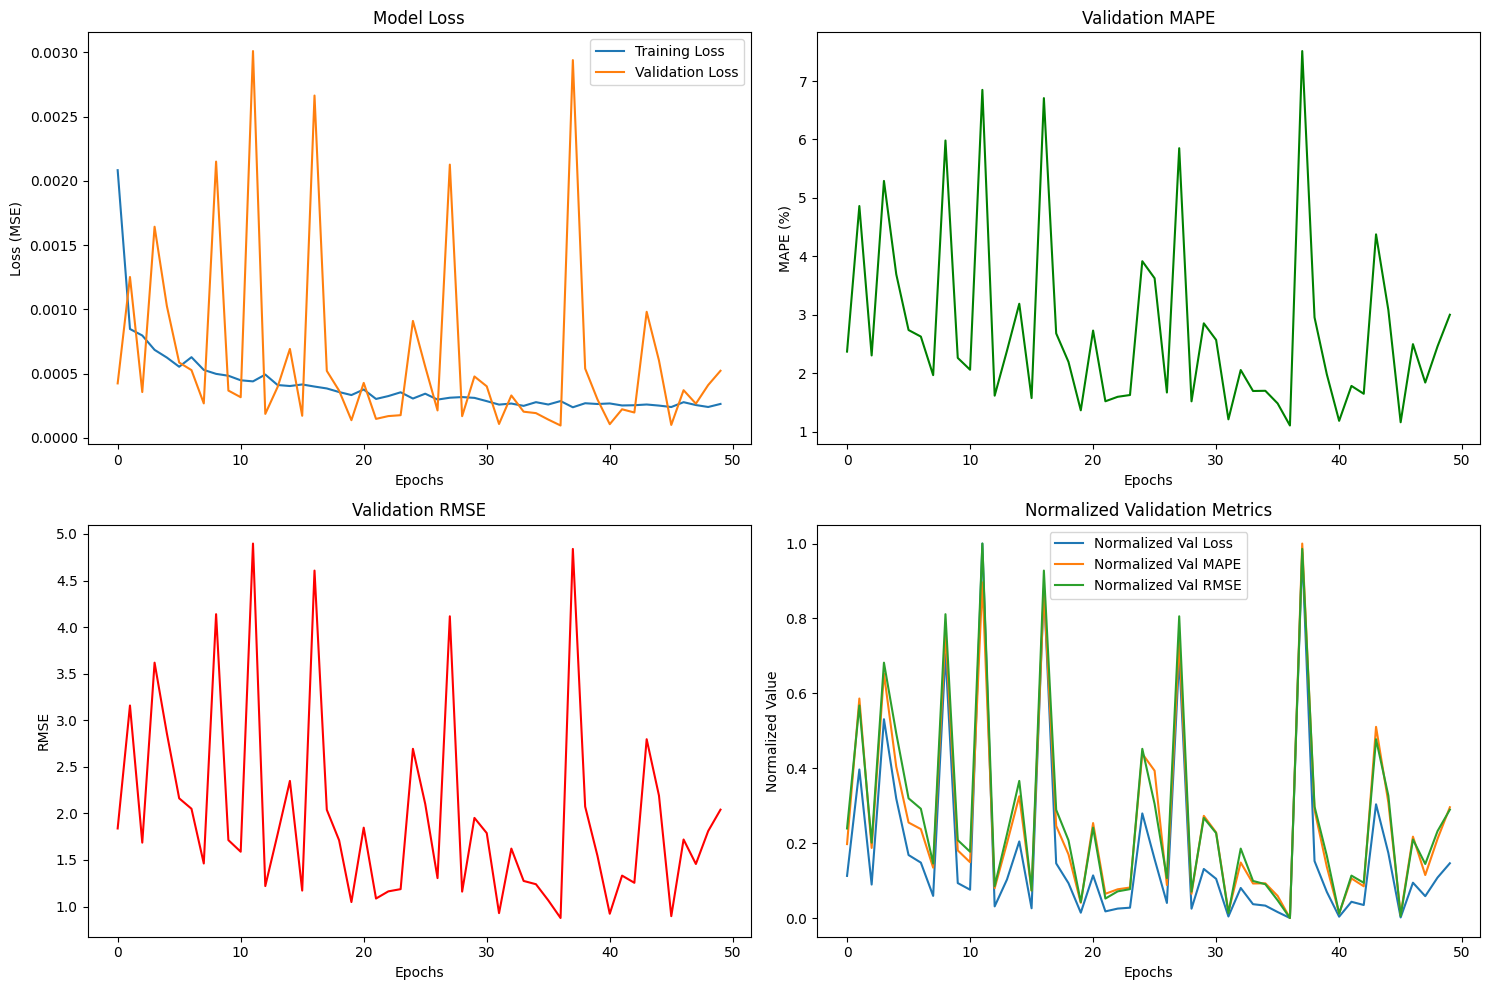

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


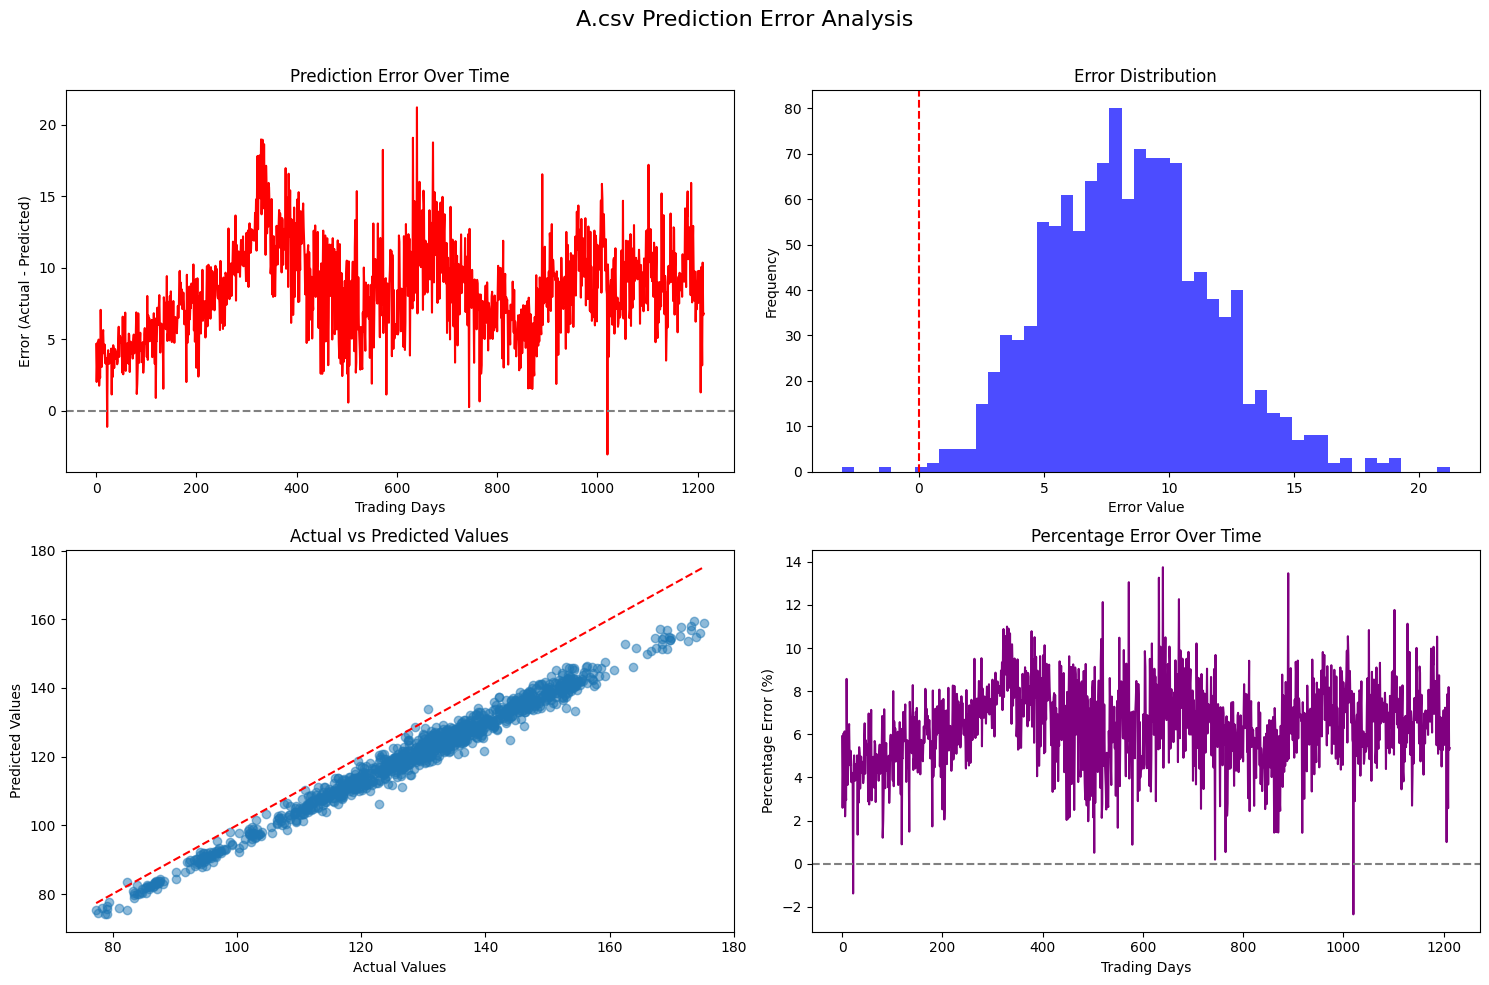


=== PREDICTION ERROR STATISTICS ===
Mean Error: 8.4219
Mean Absolute Error: 8.4288
Root Mean Squared Error: 9.0403
Mean Percentage Error: 6.3707%
Mean Absolute Percentage Error: 6.3769%

=== MULTI-STEP FORECASTING TEST ===
Error processing A.csv: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 60 and the array at index 1 has size 1213


In [ ]:
results, log_dirs = debug_all_stocks(base_path, train_path, validation_path, test_path)

Loaded model from /content/drive/My Drive/DIA TEST/debug_logs/A_20250317_015343/best_model.h5
Loaded test data from /content/drive/My Drive/DIA TEST/testing/A.csv
Test data range: 2020-02-13 00:00:00 to 2025-03-07 00:00:00 (1273 days)

Error Metrics:
Multi-step Forecasting - MAE: 2.9553, MAPE: 3.0926%
One-step Forecasting - MAE: 0.7391, MAPE: 0.7782%


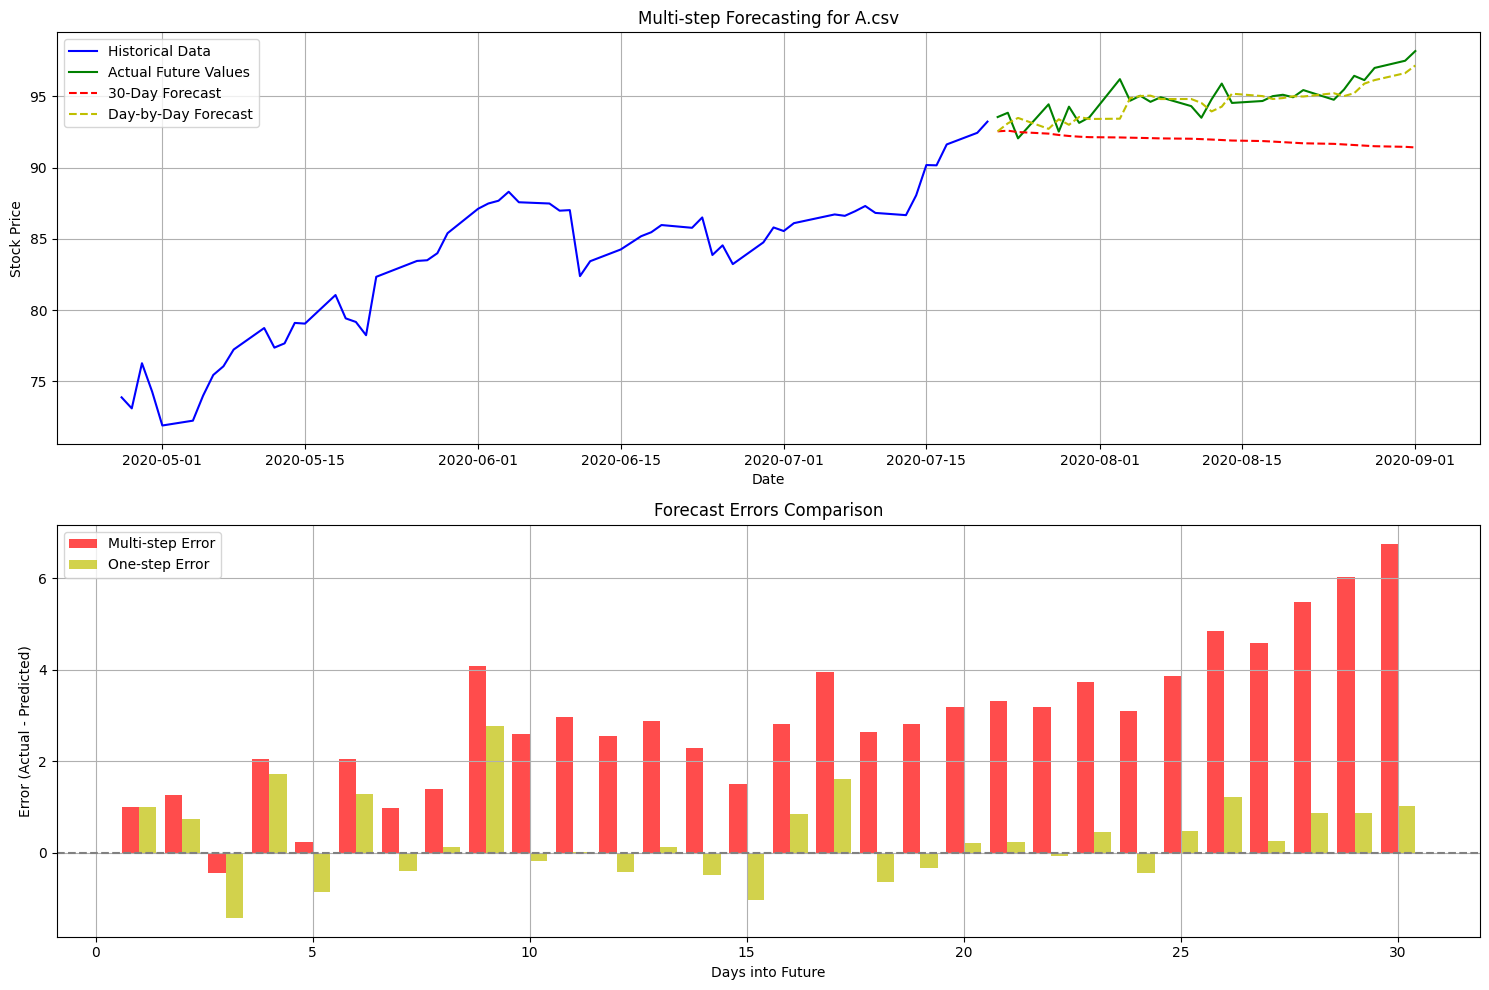

In [ ]:
import glob# Add these imports
from tensorflow.keras.models import load_model
import glob


def multi_step_forecast(model_file, stock_file, base_path, test_path, forecast_horizon=30, look_back=60, start_idx=None):
    """
    Perform multi-step forecasting with a trained model.

    Parameters:
    - model_file: Path to the saved model file
    - stock_file: Name of the stock file to use for forecasting
    - base_path, test_path: Directory paths
    - forecast_horizon: Number of days to forecast
    - look_back: Number of previous days used for prediction
    - start_idx: Index in the test data to start forecasting from (if None, uses a default position)
    """
    # Load the model
    model = load_model(model_file)
    print(f"Loaded model from {model_file}")

    # Load test data
    test_df = load_data(os.path.join(test_path, stock_file))
    print(f"Loaded test data from {os.path.join(test_path, stock_file)}")
    print(f"Test data range: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")

    # Create a scaler and scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(test_df['Close'].values.reshape(-1, 1))

    # If start_idx is not provided, use a position that leaves room for look_back and forecast_horizon
    if start_idx is None:
        start_idx = look_back + 50  # Some buffer to have enough historical data

    # Make sure start_idx is valid
    if start_idx < look_back or start_idx >= len(scaled_data) - forecast_horizon:
        print(f"Invalid start_idx. Using default value.")
        start_idx = min(look_back + 50, len(scaled_data) - forecast_horizon - 1)

    # Get the sequence of past values to start forecasting
    input_sequence = scaled_data[start_idx - look_back:start_idx, 0]

    # Save the dates for plotting
    forecast_dates = test_df['Date'].iloc[start_idx:start_idx + forecast_horizon].values
    actual_values = test_df['Close'].iloc[start_idx:start_idx + forecast_horizon].values

    # Perform multi-step forecasting
    forecasted_values = []
    current_sequence = input_sequence.copy()

    for step in range(forecast_horizon):
        # Reshape for prediction
        x_input = current_sequence.reshape(1, look_back, 1)

        # Predict next value
        next_pred = model.predict(x_input, verbose=0)[0][0]
        forecasted_values.append(next_pred)

        # Update sequence (remove oldest, add prediction)
        current_sequence = np.append(current_sequence[1:], next_pred)

    # Convert predictions back to original scale
    forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

    # For comparison, generate one-step-ahead predictions for the same period
    X_test = []
    for i in range(start_idx, start_idx + forecast_horizon):
        X_test.append(scaled_data[i-look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    one_step_predictions = model.predict(X_test, verbose=0)
    one_step_predictions = scaler.inverse_transform(one_step_predictions)

    # Calculate error metrics
    multi_step_mae = np.mean(np.abs(actual_values.reshape(-1, 1) - forecasted_values))
    multi_step_mape = np.mean(np.abs((actual_values.reshape(-1, 1) - forecasted_values) / actual_values.reshape(-1, 1))) * 100

    one_step_mae = np.mean(np.abs(actual_values.reshape(-1, 1) - one_step_predictions))
    one_step_mape = np.mean(np.abs((actual_values.reshape(-1, 1) - one_step_predictions) / actual_values.reshape(-1, 1))) * 100

    print("\nError Metrics:")
    print(f"Multi-step Forecasting - MAE: {multi_step_mae:.4f}, MAPE: {multi_step_mape:.4f}%")
    print(f"One-step Forecasting - MAE: {one_step_mae:.4f}, MAPE: {one_step_mape:.4f}%")

    # Plot results
    plt.figure(figsize=(15, 10))

    # Historical data
    historical_dates = test_df['Date'].iloc[start_idx-look_back:start_idx].values
    historical_values = test_df['Close'].iloc[start_idx-look_back:start_idx].values

    # Plot historical data
    plt.subplot(2, 1, 1)
    plt.plot(historical_dates, historical_values, 'b-', label='Historical Data')

    # Plot actual future data
    plt.plot(forecast_dates, actual_values, 'g-', label='Actual Future Values')

    # Plot multi-step forecast
    plt.plot(forecast_dates, forecasted_values, 'r--', label=f'{forecast_horizon}-Day Forecast')

    # Plot one-step forecast
    plt.plot(forecast_dates, one_step_predictions, 'y--', label='Day-by-Day Forecast')

    plt.title(f'Multi-step Forecasting for {stock_file}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    # Plot error comparison
    plt.subplot(2, 1, 2)

    # Multi-step forecast errors
    multi_step_errors = actual_values.reshape(-1) - forecasted_values.reshape(-1)
    one_step_errors = actual_values.reshape(-1) - one_step_predictions.reshape(-1)

    days = np.arange(1, forecast_horizon + 1)
    plt.bar(days - 0.2, multi_step_errors, width=0.4, color='r', alpha=0.7, label='Multi-step Error')
    plt.bar(days + 0.2, one_step_errors, width=0.4, color='y', alpha=0.7, label='One-step Error')

    plt.axhline(y=0, color='grey', linestyle='--')
    plt.title('Forecast Errors Comparison')
    plt.xlabel('Days into Future')
    plt.ylabel('Error (Actual - Predicted)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return forecasted_values, one_step_predictions, actual_values

# Usage example (run this in a new cell):
# Find the most recent model file for a stock
model_files = glob.glob(os.path.join(base_path, 'debug_logs', 'A_*', 'best_model.h5'))
if model_files:
    latest_model = sorted(model_files)[-1]
    forecasted, one_step, actual = multi_step_forecast(
        model_file=latest_model,
        stock_file='A.csv',
        base_path=base_path,
        test_path=test_path,
        forecast_horizon=30
    )


TO TEST THE SAME MODEL ON DIFFERENT STOCKS

Testing model trained on A.csv with data from AA.csv
Loaded model from /content/drive/My Drive/DIA TEST/debug_logs/A_20250317_015343/best_model.h5

New stock data summary:
Training data range: 1962-01-02 00:00:00 to 1999-11-19 00:00:00 (9541 days)
Validation data range: 1999-11-22 00:00:00 to 2012-07-12 00:00:00 (3180 days)
Testing data range: 2012-07-13 00:00:00 to 2025-03-07 00:00:00 (3181 days)
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Prediction Results for AA.csv using model trained on A.csv:
Mean Absolute Error: 0.8256
Mean Absolute Percentage Error: 2.7992%
Root Mean Squared Error: 1.2177


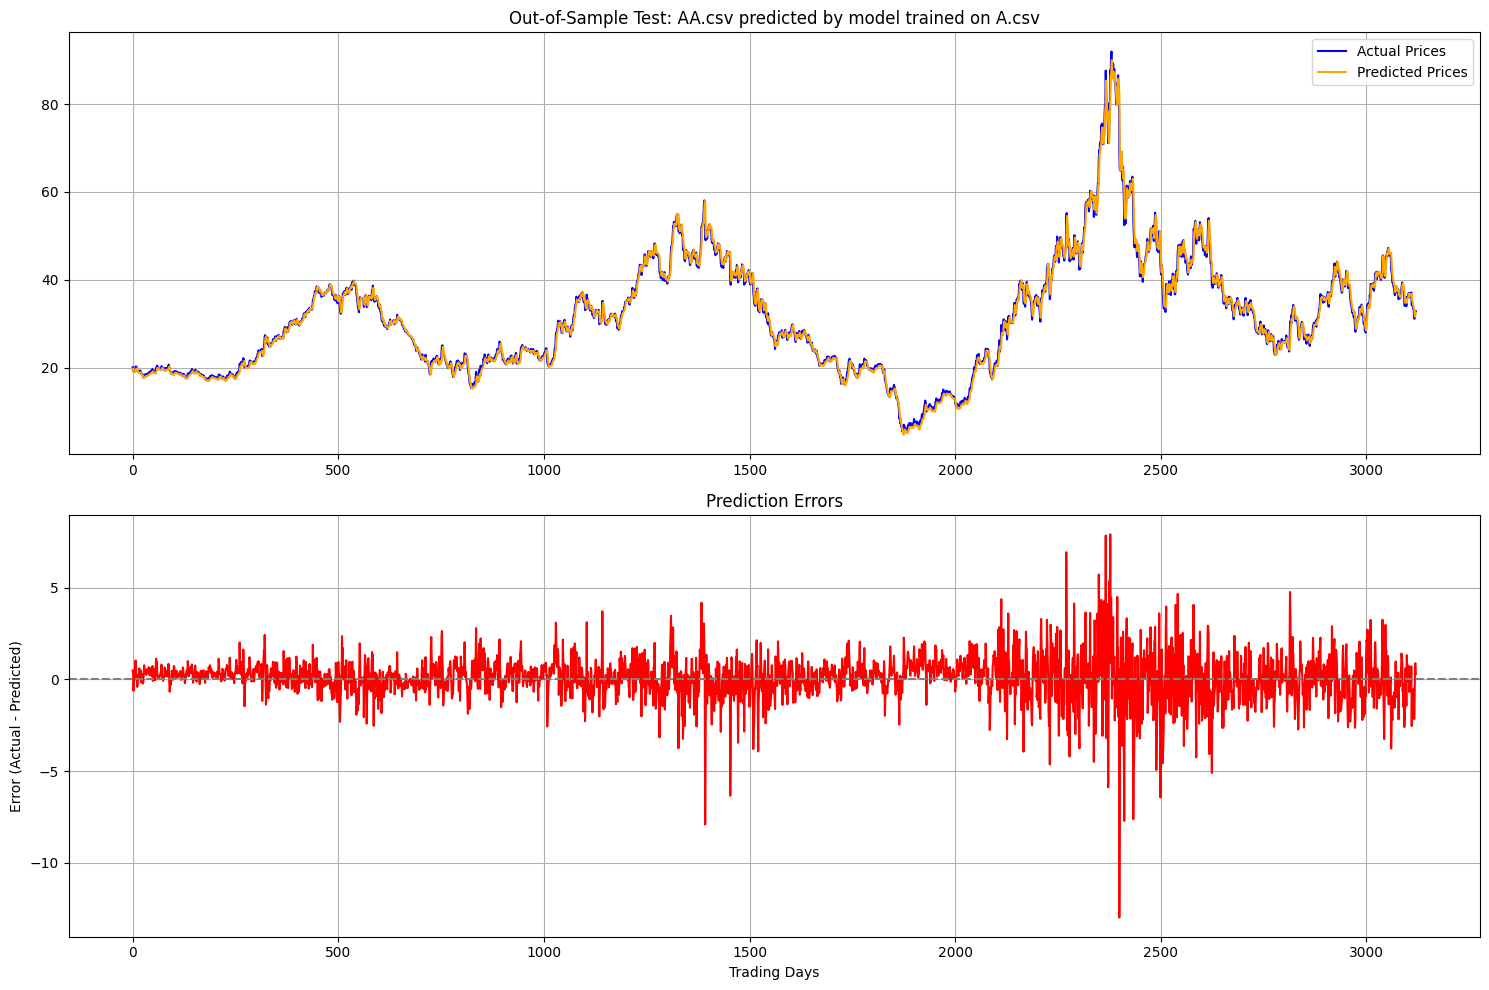

In [ ]:
base_path = '/content/drive/My Drive/DIA DATASET/'
train_path = os.path.join(base_path, 'training')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'testing')


def test_on_different_stock(trained_model_stock, test_stock, base_path, train_path, validation_path, test_path):
    """
    Test a model trained on one stock with data from a different stock.

    Parameters:
    - trained_model_stock: Name of the stock file used for training (e.g., 'A.csv')
    - test_stock: Name of the new stock file to test on (e.g., 'AAPL.csv')
    - base_path, train_path, validation_path, test_path: Directory paths
    """
    print(f"Testing model trained on {trained_model_stock} with data from {test_stock}")

    # Step 1: Load the trained model
    model_path = os.path.join(base_path, 'debug_logs', f"{trained_model_stock.split('.')[0]}_*", 'best_model.h5')
    model_files = glob.glob(model_path)

    if not model_files:
        print(f"No trained model found for {trained_model_stock}. Please train the model first.")
        return

    # Load the most recent model
    model_path = sorted(model_files)[-1]
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")

    # Step 2: Load data for the new stock
    train_df = load_data(os.path.join(train_path, test_stock))
    val_df = load_data(os.path.join(validation_path, test_stock))
    test_df = load_data(os.path.join(test_path, test_stock))

    # Print basic info about the new stock
    print(f"\nNew stock data summary:")
    print(f"Training data range: {train_df['Date'].min()} to {train_df['Date'].max()} ({len(train_df)} days)")
    print(f"Validation data range: {val_df['Date'].min()} to {val_df['Date'].max()} ({len(val_df)} days)")
    print(f"Testing data range: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")

    # Step 3: Prepare data
    # look_back = 60  # Make sure this matches your trained model's parameter

    # Create a new scaler for the new stock
    scaler = MinMaxScaler(feature_range=(0, 1))
    look_back = 60  # Make sure this matches your trained model's parameter

    # Option 1: Let prepare_data create and fit a new scaler
    X_test, y_test, scaler = prepare_data(test_df, scaler=None, look_back=look_back)

    # Step 4: Generate predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Step 5: Calculate errors
    mae = np.mean(np.abs(y_test_inv - predictions))
    mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100
    rmse = np.sqrt(np.mean(np.square(y_test_inv - predictions)))

    print(f"\nPrediction Results for {test_stock} using model trained on {trained_model_stock}:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4f}%")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    # Step 6: Visualize results
    plt.figure(figsize=(15, 10))

    # Plot 1: Actual vs Predicted Prices
    plt.subplot(2, 1, 1)
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title(f'Out-of-Sample Test: {test_stock} predicted by model trained on {trained_model_stock}')
    plt.legend()
    plt.grid(True)

    # Plot 2: Prediction Errors
    plt.subplot(2, 1, 2)
    errors = y_test_inv - predictions
    plt.plot(errors, color='red')
    plt.title('Prediction Errors')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, predictions, y_test_inv

# Usage example (run this in a new cell):
import glob  # Add this import at the top of your script
trained_model_stock = 'A.csv'  # Stock used for training
test_stock = 'AA.csv'  # New stock to test on
model, predictions, actual = test_on_different_stock(trained_model_stock, test_stock, '/content/drive/My Drive/DIA TEST/', train_path, validation_path, test_path)


Testing model trained on A.csv with data from ACET.csv
Loaded model from /content/drive/My Drive/DIA TEST/debug_logs/A_20250317_015343/best_model.h5

New stock data summary:
Training data range: 2018-01-26 00:00:00 to 2022-04-28 00:00:00 (1072 days)
Validation data range: 2022-04-29 00:00:00 to 2023-10-02 00:00:00 (358 days)
Testing data range: 2023-10-03 00:00:00 to 2025-03-07 00:00:00 (358 days)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

Prediction Results for ACET.csv using model trained on A.csv:
Mean Absolute Error: 0.0743
Mean Absolute Percentage Error: 4.5567%
Root Mean Squared Error: 0.1155

Trading Simulation Results:
Initial Capital: $10000.00
Final Portfolio Value: $8335.75
Total Return: -16.64%


<Figure size 1500x1500 with 0 Axes>

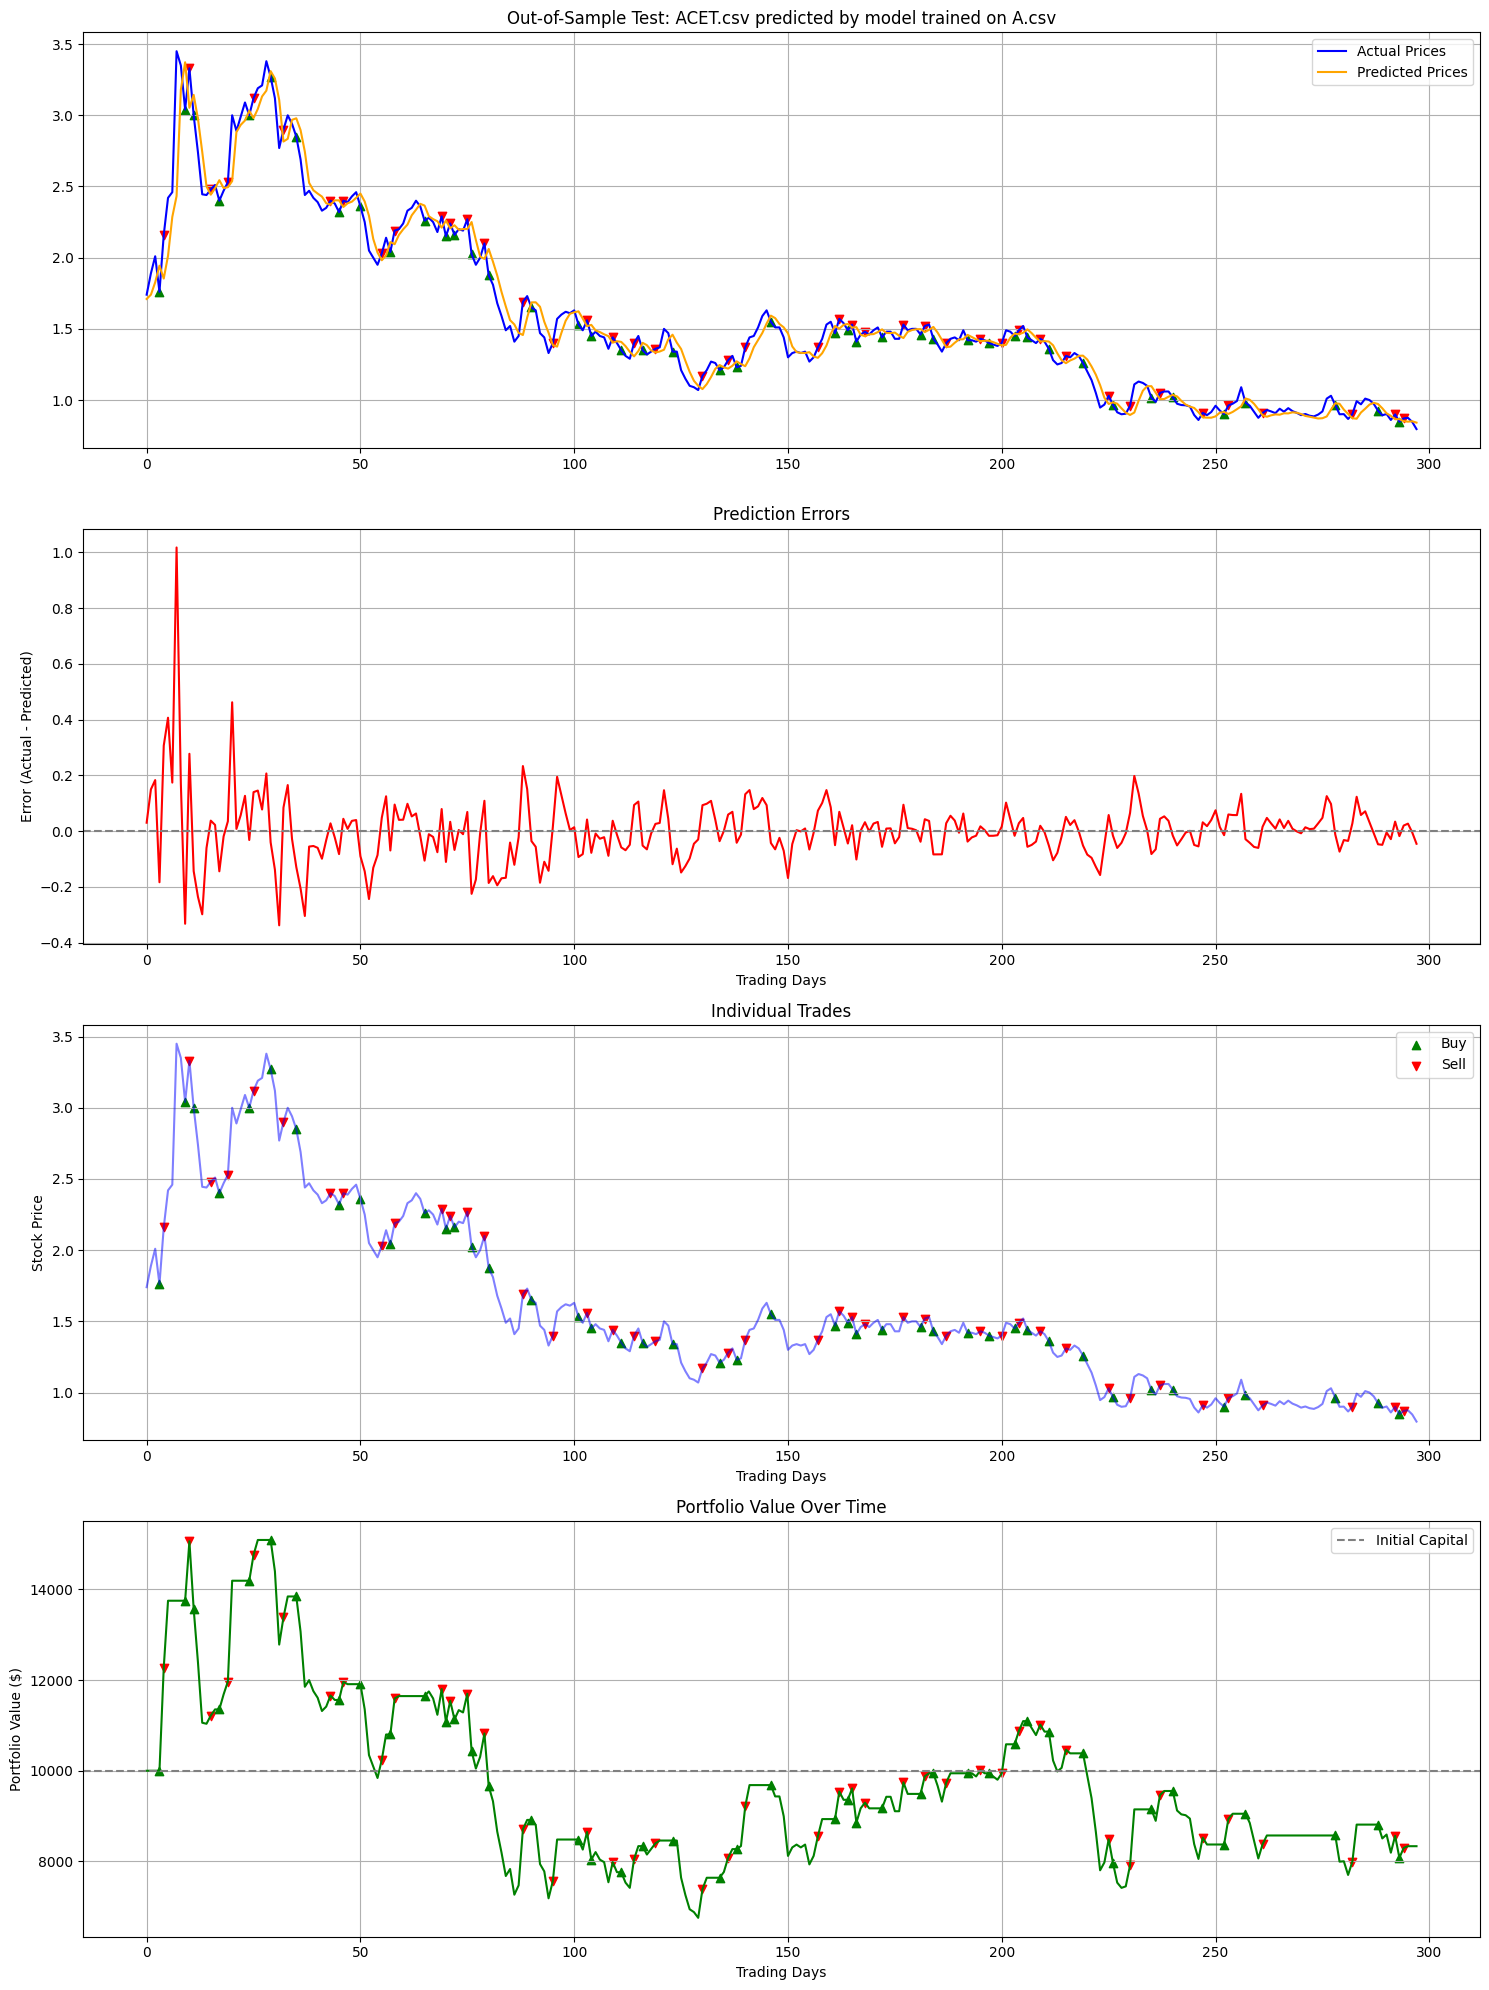

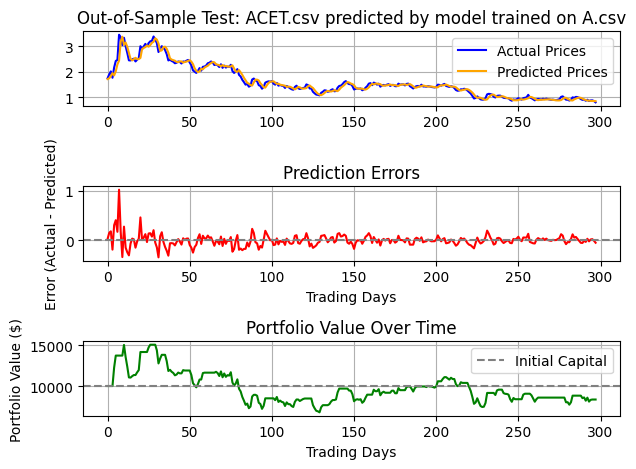

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import re
import glob

base_path = '/content/drive/My Drive/DIA DATASET/'
train_path = os.path.join(base_path, 'training')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'testing')

def load_data(file_path):
    """Load stock data properly handling the CSV file format with metadata headers."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data_start = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('Date'):
            data_start = i + 1
            break

    df = pd.read_csv(file_path, skiprows=data_start, header=None)

    columns = ['Date']
    for i in range(1, df.shape[1]):
        columns.append(f'Value{i}')
    df.columns = columns

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Close'] = pd.to_numeric(df['Value1'], errors='coerce')
    df = df[~df['Date'].isna() & ~df['Close'].isna()].reset_index(drop=True)
    df = df.sort_values('Date')

    return df

def prepare_data(df, scaler=None, look_back=60):
    """Prepare time series data for LSTM model."""
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    else:
        scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

def simulate_trading(predictions, actual_values, initial_capital=10000):
    """
    Simulate a simple trading strategy based on predictions and calculate portfolio value changes.
    """
    position = 0
    portfolio_value = [initial_capital]
    trades = []

    for i in range(1, len(predictions)):
        current_price = actual_values[i-1][0]
        next_price = actual_values[i][0]
        predicted_next = predictions[i-1][0]

        if predicted_next > current_price * 1.01 and position == 0:
            position = portfolio_value[-1] / current_price
            portfolio_value.append(position * next_price)
            trades.append('Buy')
        elif predicted_next < current_price * 0.99 and position > 0:
            portfolio_value.append(position * next_price)
            position = 0
            trades.append('Sell')
        else:
            if position > 0:
                portfolio_value.append(position * next_price)
            else:
                portfolio_value.append(portfolio_value[-1])
            trades.append('Hold')

    return portfolio_value, trades

def test_on_different_stock(trained_model_stock, test_stock, base_path, train_path, validation_path, test_path):
    """
    Test a model trained on one stock with data from a different stock.
    """
    print(f"Testing model trained on {trained_model_stock} with data from {test_stock}")

    model_path = os.path.join(base_path, 'debug_logs', f"{trained_model_stock.split('.')[0]}_*", 'best_model.h5')
    model_files = glob.glob(model_path)

    if not model_files:
        print(f"No trained model found for {trained_model_stock}. Please train the model first.")
        return

    model_path = sorted(model_files)[-1]
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")

    train_df = load_data(os.path.join(train_path, test_stock))
    val_df = load_data(os.path.join(validation_path, test_stock))
    test_df = load_data(os.path.join(test_path, test_stock))

    print(f"\nNew stock data summary:")
    print(f"Training data range: {train_df['Date'].min()} to {train_df['Date'].max()} ({len(train_df)} days)")
    print(f"Validation data range: {val_df['Date'].min()} to {val_df['Date'].max()} ({len(val_df)} days)")
    print(f"Testing data range: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")

    scaler = MinMaxScaler(feature_range=(0, 1))
    look_back = 60

    X_test, y_test, scaler = prepare_data(test_df, scaler=None, look_back=look_back)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = np.mean(np.abs(y_test_inv - predictions))
    mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100
    rmse = np.sqrt(np.mean(np.square(y_test_inv - predictions)))

    print(f"\nPrediction Results for {test_stock} using model trained on {trained_model_stock}:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4f}%")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    portfolio_values, trades = simulate_trading(predictions, y_test_inv)

    initial_capital = 10000
    final_value = portfolio_values[-1]
    total_return = ((final_value - initial_capital) / initial_capital) * 100

    print(f"\nTrading Simulation Results:")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")

    plt.figure(figsize=(15, 15))

        # Step 7: Visualize results
    plt.figure(figsize=(15, 20))

    # Plot 1: Actual vs Predicted Prices with Buy/Sell markers
    plt.subplot(4, 1, 1)
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    for i, trade in enumerate(trades):
        if trade == 'Buy':
            plt.scatter(i, y_test_inv[i], color='green', marker='^')
        elif trade == 'Sell':
            plt.scatter(i, y_test_inv[i], color='red', marker='v')
    plt.title(f'Out-of-Sample Test: {test_stock} predicted by model trained on {trained_model_stock}')
    plt.legend()
    plt.grid(True)

    # Plot 2: Prediction Errors
    plt.subplot(4, 1, 2)
    errors = y_test_inv - predictions
    plt.plot(errors, color='red')
    plt.title('Prediction Errors')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True)

    # Plot 3: Individual Trades
    plt.subplot(4, 1, 3)
    plt.plot(y_test_inv, color='blue', alpha=0.5)
    buy_points = [i for i, trade in enumerate(trades) if trade == 'Buy']
    sell_points = [i for i, trade in enumerate(trades) if trade == 'Sell']
    plt.scatter(buy_points, [y_test_inv[i] for i in buy_points], color='green', marker='^', label='Buy')
    plt.scatter(sell_points, [y_test_inv[i] for i in sell_points], color='red', marker='v', label='Sell')
    plt.title('Individual Trades')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    # Plot 4: Portfolio Value
    plt.subplot(4, 1, 4)
    plt.plot(portfolio_values, color='green')
    for i, trade in enumerate(trades):
        if trade == 'Buy':
            plt.scatter(i, portfolio_values[i], color='green', marker='^')
        elif trade == 'Sell':
            plt.scatter(i, portfolio_values[i], color='red', marker='v')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_capital, color='grey', linestyle='--', label='Initial Capital')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


    plt.subplot(3, 1, 1)
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title(f'Out-of-Sample Test: {test_stock} predicted by model trained on {trained_model_stock}')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    errors = y_test_inv - predictions
    plt.plot(errors, color='red')
    plt.title('Prediction Errors')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(portfolio_values, color='green')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_capital, color='grey', linestyle='--', label='Initial Capital')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, predictions, y_test_inv

# Usage example
trained_model_stock = 'A.csv'
test_stock = 'ACET.csv'
model, predictions, actual = test_on_different_stock(trained_model_stock, test_stock, '/content/drive/My Drive/DIA TEST/', train_path, validation_path, test_path)


Testing model trained on A.csv with data from A.csv
Loaded model from /content/drive/My Drive/DIA TEST/debug_logs/A_20250317_015343/best_model.h5

New stock data summary:
Training data range: 1999-11-18 00:00:00 to 2015-01-22 00:00:00 (3817 days)
Validation data range: 2015-01-23 00:00:00 to 2020-02-12 00:00:00 (1273 days)
Testing data range: 2020-02-13 00:00:00 to 2025-03-07 00:00:00 (1273 days)
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Prediction Results for A.csv using model trained on A.csv:
Mean Absolute Error: 1.7397
Mean Absolute Percentage Error: 1.3567%
Root Mean Squared Error: 2.3345

Trading Simulation Results:
Initial Capital: $10000.00
Final Portfolio Value: $19611.35
Total Return: 96.11%


<Figure size 1500x1500 with 0 Axes>

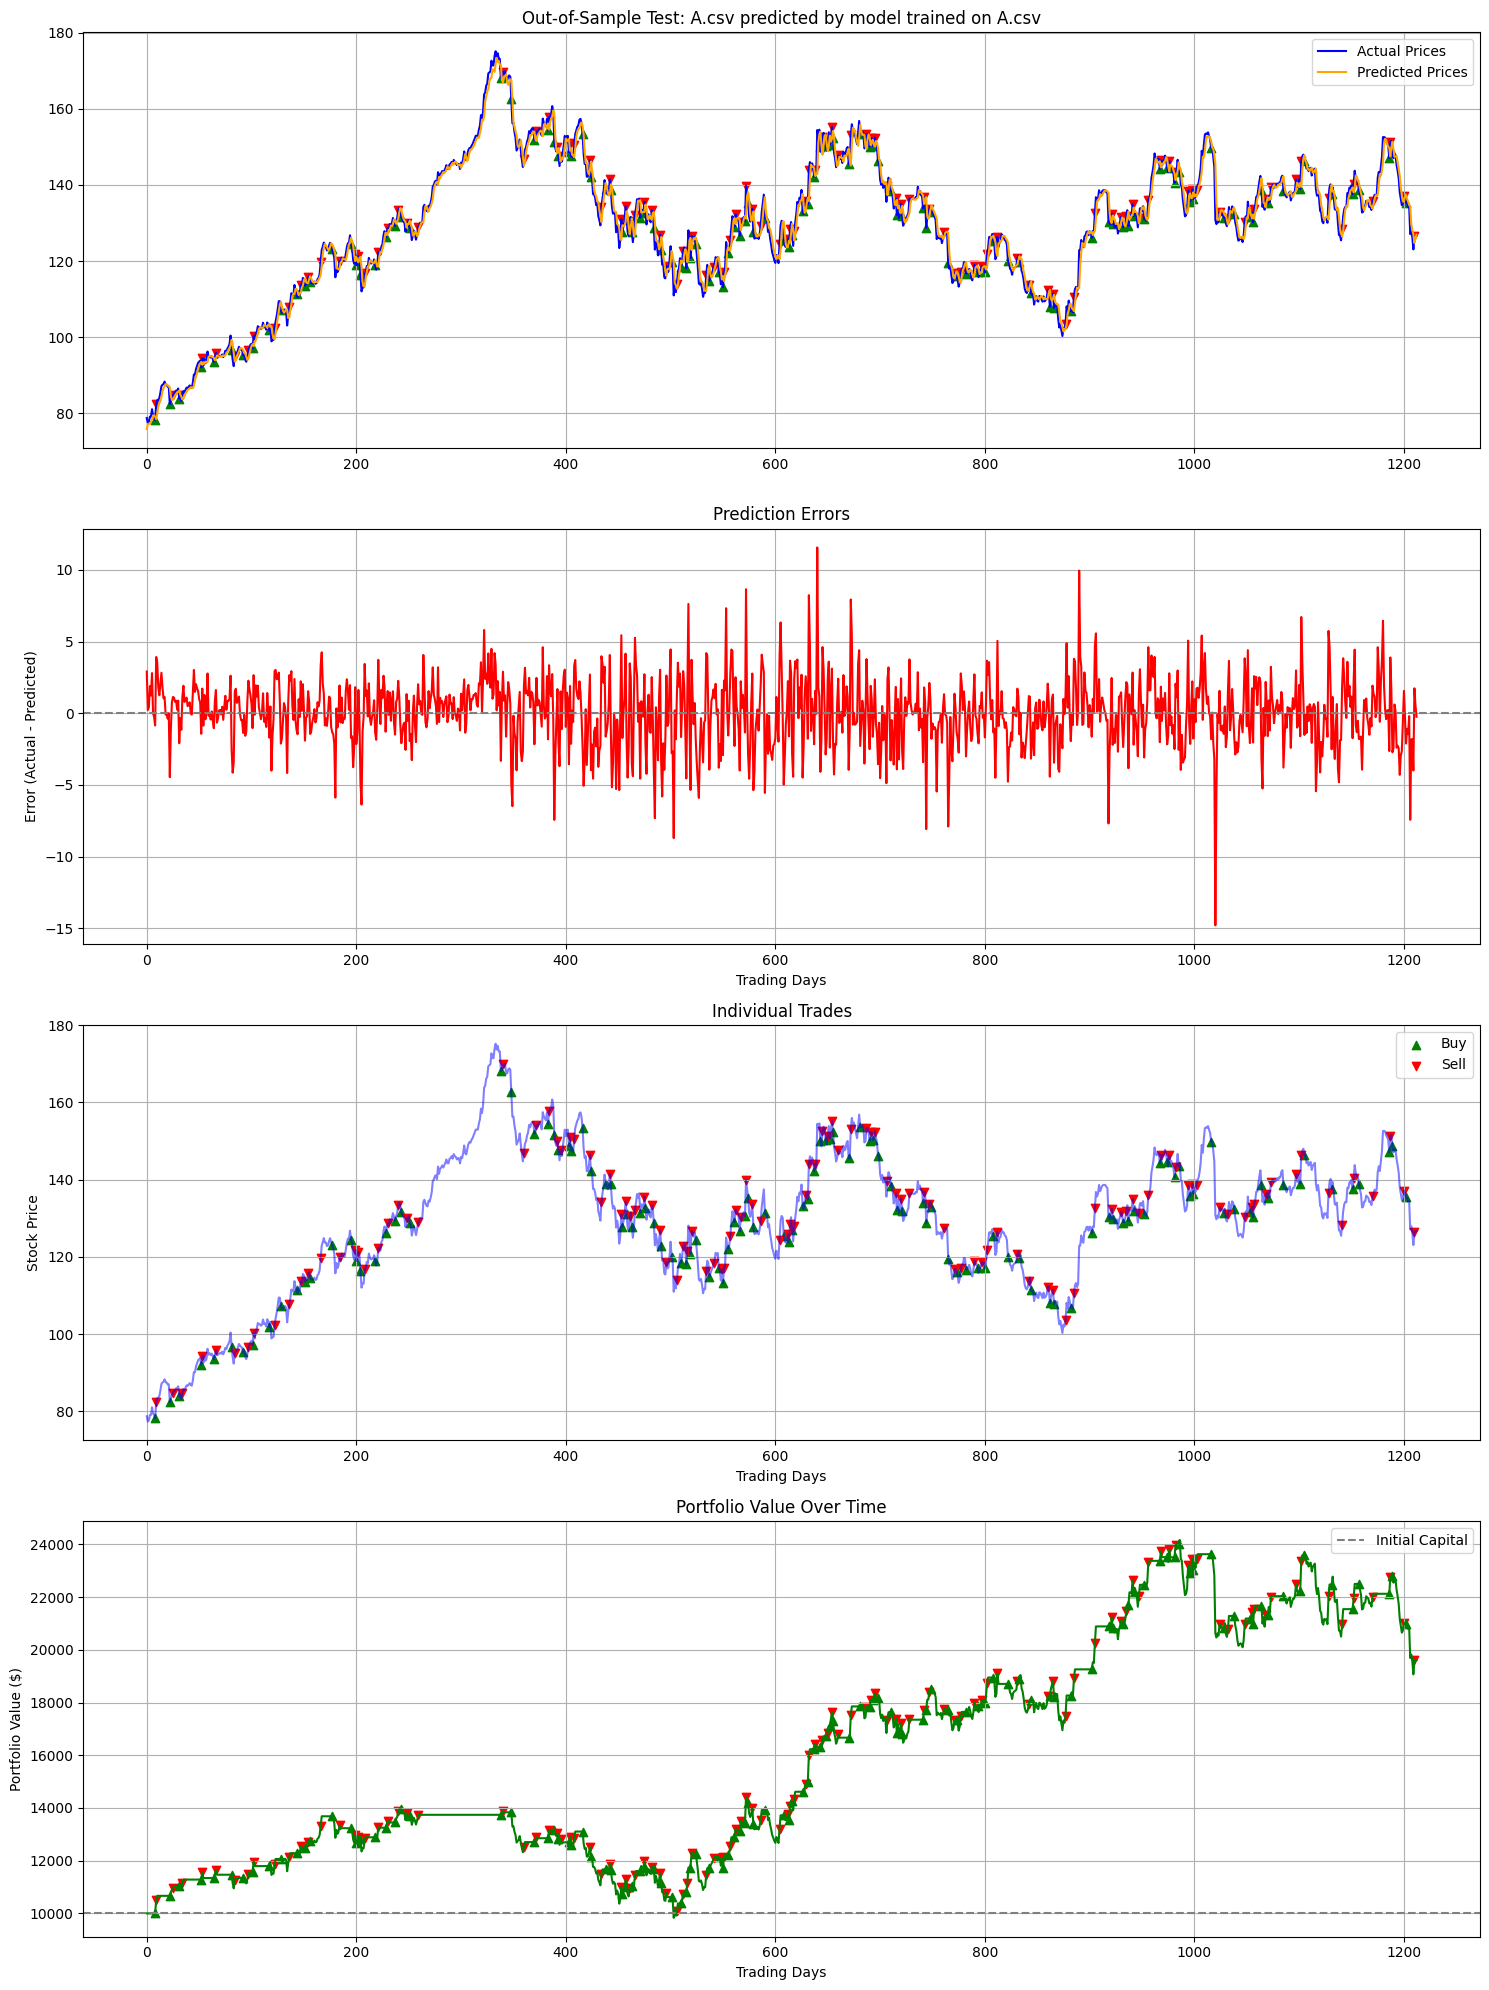

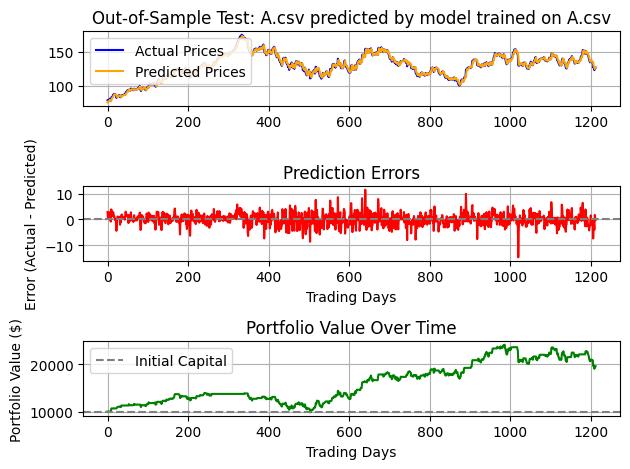

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import re
import glob

base_path = '/content/drive/My Drive/DIA DATASET/'
train_path = os.path.join(base_path, 'training')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'testing')

def load_data(file_path):
    """Load stock data properly handling the CSV file format with metadata headers."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data_start = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('Date'):
            data_start = i + 1
            break

    df = pd.read_csv(file_path, skiprows=data_start, header=None)

    columns = ['Date']
    for i in range(1, df.shape[1]):
        columns.append(f'Value{i}')
    df.columns = columns

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Close'] = pd.to_numeric(df['Value1'], errors='coerce')
    df = df[~df['Date'].isna() & ~df['Close'].isna()].reset_index(drop=True)
    df = df.sort_values('Date')

    return df

def prepare_data(df, scaler=None, look_back=60):
    """Prepare time series data for LSTM model."""
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    else:
        scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

def simulate_trading(predictions, actual_values, initial_capital=10000):
    """
    Simulate a simple trading strategy based on predictions and calculate portfolio value changes.
    """
    position = 0
    portfolio_value = [initial_capital]
    trades = []

    for i in range(1, len(predictions)):
        current_price = actual_values[i-1][0]
        next_price = actual_values[i][0]
        predicted_next = predictions[i-1][0]

        if predicted_next > current_price * 1.01 and position == 0:
            position = portfolio_value[-1] / current_price
            portfolio_value.append(position * next_price)
            trades.append('Buy')
        elif predicted_next < current_price * 0.99 and position > 0:
            portfolio_value.append(position * next_price)
            position = 0
            trades.append('Sell')
        else:
            if position > 0:
                portfolio_value.append(position * next_price)
            else:
                portfolio_value.append(portfolio_value[-1])
            trades.append('Hold')

    return portfolio_value, trades

def test_on_different_stock(trained_model_stock, test_stock, base_path, train_path, validation_path, test_path):
    """
    Test a model trained on one stock with data from a different stock.
    """
    print(f"Testing model trained on {trained_model_stock} with data from {test_stock}")

    model_path = os.path.join(base_path, 'debug_logs', f"{trained_model_stock.split('.')[0]}_*", 'best_model.h5')
    model_files = glob.glob(model_path)

    if not model_files:
        print(f"No trained model found for {trained_model_stock}. Please train the model first.")
        return

    model_path = sorted(model_files)[-1]
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")

    train_df = load_data(os.path.join(train_path, test_stock))
    val_df = load_data(os.path.join(validation_path, test_stock))
    test_df = load_data(os.path.join(test_path, test_stock))

    print(f"\nNew stock data summary:")
    print(f"Training data range: {train_df['Date'].min()} to {train_df['Date'].max()} ({len(train_df)} days)")
    print(f"Validation data range: {val_df['Date'].min()} to {val_df['Date'].max()} ({len(val_df)} days)")
    print(f"Testing data range: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")

    scaler = MinMaxScaler(feature_range=(0, 1))
    look_back = 60

    X_test, y_test, scaler = prepare_data(test_df, scaler=None, look_back=look_back)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = np.mean(np.abs(y_test_inv - predictions))
    mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100
    rmse = np.sqrt(np.mean(np.square(y_test_inv - predictions)))

    print(f"\nPrediction Results for {test_stock} using model trained on {trained_model_stock}:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4f}%")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    portfolio_values, trades = simulate_trading(predictions, y_test_inv)

    initial_capital = 10000
    final_value = portfolio_values[-1]
    total_return = ((final_value - initial_capital) / initial_capital) * 100

    print(f"\nTrading Simulation Results:")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")

    plt.figure(figsize=(15, 15))

        # Step 7: Visualize results
    plt.figure(figsize=(15, 20))

    # Plot 1: Actual vs Predicted Prices with Buy/Sell markers
    plt.subplot(4, 1, 1)
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    for i, trade in enumerate(trades):
        if trade == 'Buy':
            plt.scatter(i, y_test_inv[i], color='green', marker='^')
        elif trade == 'Sell':
            plt.scatter(i, y_test_inv[i], color='red', marker='v')
    plt.title(f'Out-of-Sample Test: {test_stock} predicted by model trained on {trained_model_stock}')
    plt.legend()
    plt.grid(True)

    # Plot 2: Prediction Errors
    plt.subplot(4, 1, 2)
    errors = y_test_inv - predictions
    plt.plot(errors, color='red')
    plt.title('Prediction Errors')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True)

    # Plot 3: Individual Trades
    plt.subplot(4, 1, 3)
    plt.plot(y_test_inv, color='blue', alpha=0.5)
    buy_points = [i for i, trade in enumerate(trades) if trade == 'Buy']
    sell_points = [i for i, trade in enumerate(trades) if trade == 'Sell']
    plt.scatter(buy_points, [y_test_inv[i] for i in buy_points], color='green', marker='^', label='Buy')
    plt.scatter(sell_points, [y_test_inv[i] for i in sell_points], color='red', marker='v', label='Sell')
    plt.title('Individual Trades')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    # Plot 4: Portfolio Value
    plt.subplot(4, 1, 4)
    plt.plot(portfolio_values, color='green')
    for i, trade in enumerate(trades):
        if trade == 'Buy':
            plt.scatter(i, portfolio_values[i], color='green', marker='^')
        elif trade == 'Sell':
            plt.scatter(i, portfolio_values[i], color='red', marker='v')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_capital, color='grey', linestyle='--', label='Initial Capital')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


    plt.subplot(3, 1, 1)
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title(f'Out-of-Sample Test: {test_stock} predicted by model trained on {trained_model_stock}')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    errors = y_test_inv - predictions
    plt.plot(errors, color='red')
    plt.title('Prediction Errors')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(portfolio_values, color='green')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_capital, color='grey', linestyle='--', label='Initial Capital')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, predictions, y_test_inv

# Usage example
trained_model_stock = 'A.csv'
test_stock = 'A.csv'
model, predictions, actual = test_on_different_stock(trained_model_stock, test_stock, '/content/drive/My Drive/DIA TEST/', train_path, validation_path, test_path)


Testing model trained on A.csv with data from ACET.csv
Loaded model from /content/drive/My Drive/DIA TEST/debug_logs/A_20250317_015343/best_model.h5

New stock data summary:
Training data range: 2018-01-26 00:00:00 to 2022-04-28 00:00:00 (1072 days)
Validation data range: 2022-04-29 00:00:00 to 2023-10-02 00:00:00 (358 days)
Testing data range: 2023-10-03 00:00:00 to 2025-03-07 00:00:00 (358 days)
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step

Prediction Results for ACET.csv using model trained on A.csv:
Mean Absolute Error: 0.0743
Mean Absolute Percentage Error: 4.5567%
Root Mean Squared Error: 0.1155

Trading Simulation Results:
Initial Capital: $10000.00
Final Portfolio Value: $8335.75
Total Return: -16.64%


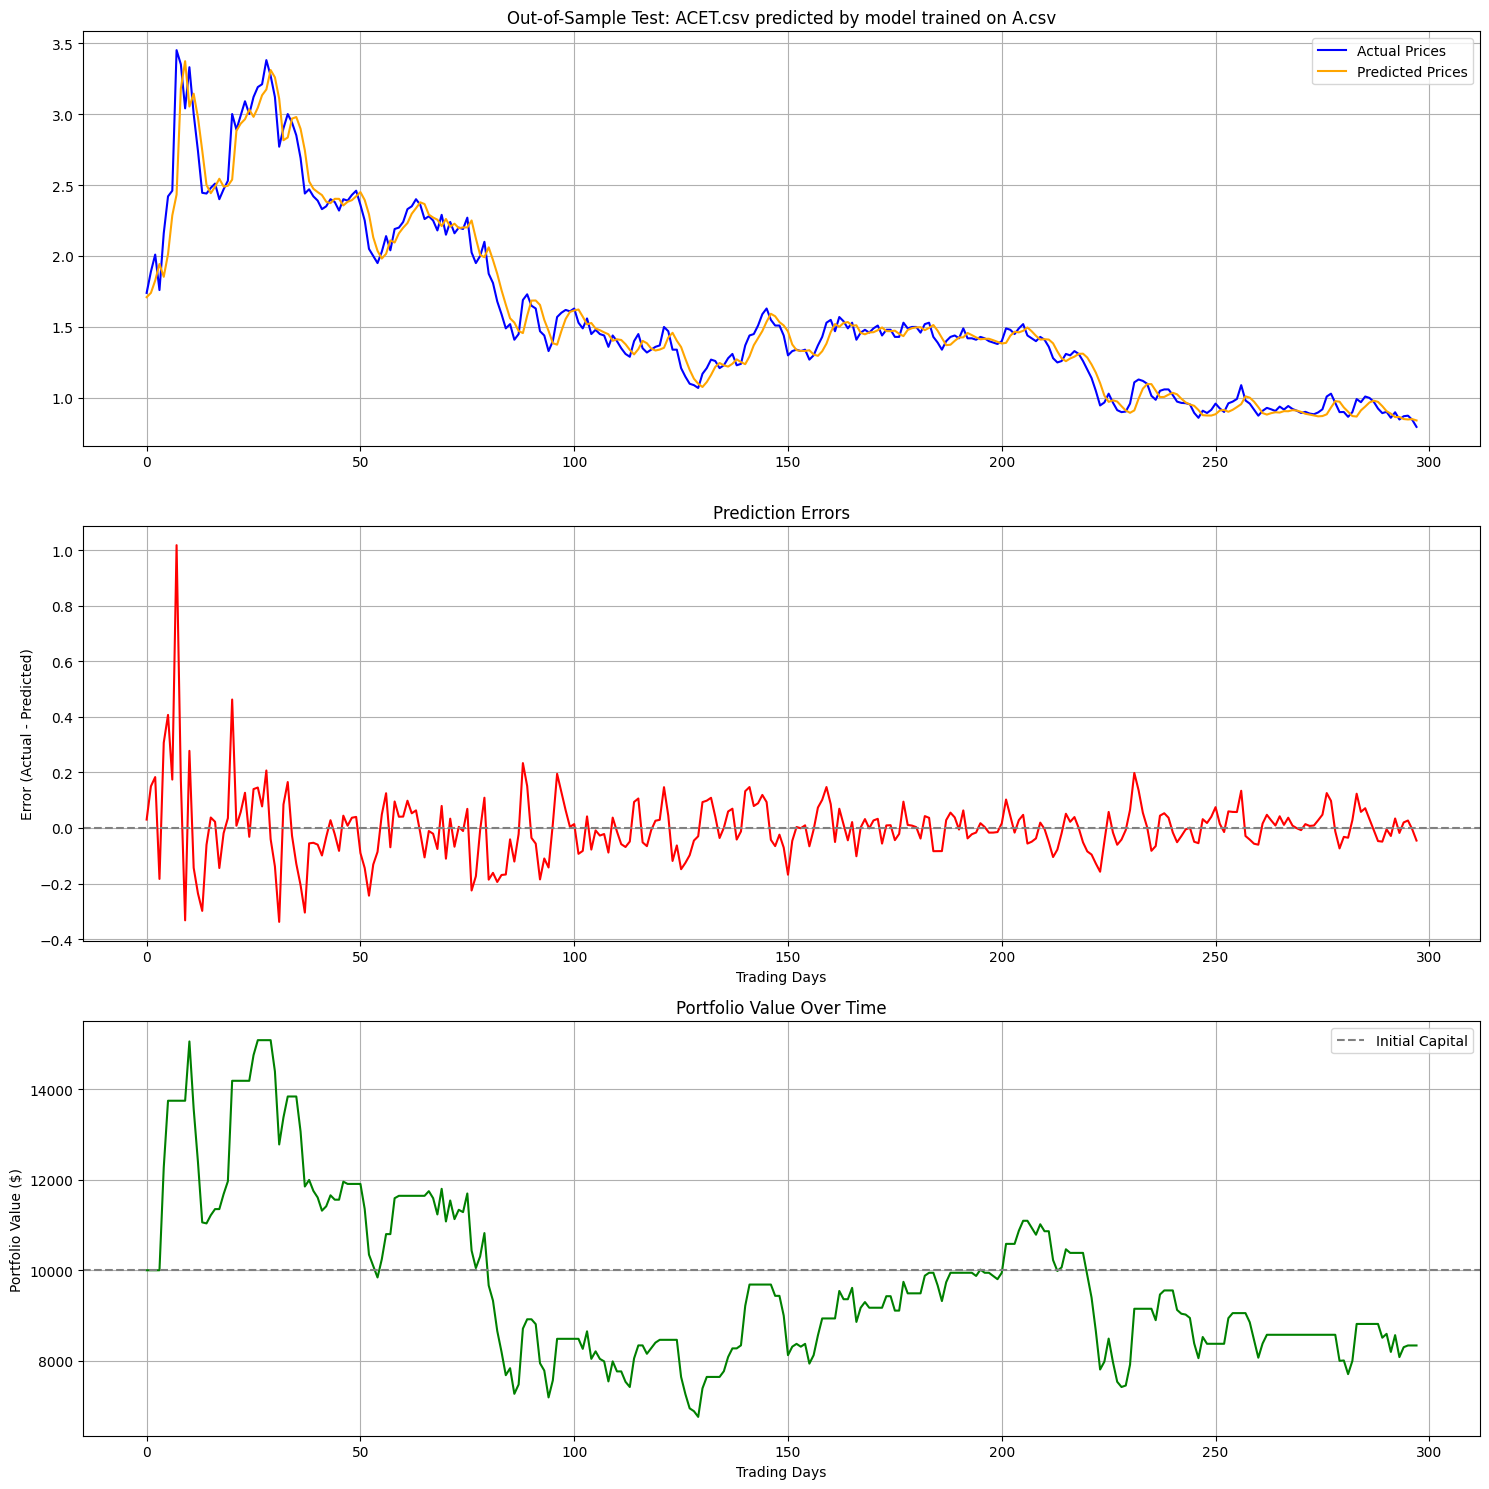

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import re


from tensorflow.keras.models import load_model
base_path = '/content/drive/My Drive/DIA DATASET/'
train_path = os.path.join(base_path, 'training')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'testing')


def load_data(file_path):
    """Load stock data properly handling the CSV file format with metadata headers."""
    # Read the file with no specific header to examine structure
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Find where the actual data starts (after the 'Date' row)
    data_start = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('Date'):
            data_start = i + 1
            break

    # Read the CSV file again, now skipping metadata rows
    df = pd.read_csv(file_path, skiprows=data_start, header=None)

    # Name the columns appropriately
    columns = ['Date']
    for i in range(1, df.shape[1]):
        columns.append(f'Value{i}')
    df.columns = columns

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Use the second column as Close price
    df['Close'] = pd.to_numeric(df['Value1'], errors='coerce')

    # Filter out rows with invalid data
    df = df[~df['Date'].isna() & ~df['Close'].isna()].reset_index(drop=True)

    # Sort by date
    df = df.sort_values('Date')

    return df


def prepare_data(df, scaler=None, look_back=60):
    """Prepare time series data for LSTM model."""
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    else:
        scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Add trading simulation function
def simulate_trading(predictions, actual_values, initial_capital=10000):
    """
    Simulate a simple trading strategy based on predictions and calculate portfolio value changes.

    Parameters:
    - predictions: Predicted stock prices (numpy array)
    - actual_values: Actual stock prices (numpy array)
    - initial_capital: Starting capital for trading (default: $10,000)

    Returns:
    - portfolio_values: List of portfolio values over time
    - trades: List of trades (buy/sell/hold)
    """
    position = 0  # Number of shares held
    portfolio_value = [initial_capital]  # Track portfolio value over time
    trades = []  # Track buy/sell decisions

    for i in range(1, len(predictions)):
        current_price = actual_values[i-1][0]
        next_price = actual_values[i][0]
        predicted_next = predictions[i-1][0]

        if predicted_next > current_price * 1.01 and position == 0:
            # Buy
            position = portfolio_value[-1] / current_price
            portfolio_value.append(position * next_price)
            trades.append('Buy')
        elif predicted_next < current_price * 0.99 and position > 0:
            # Sell
            portfolio_value.append(position * next_price)
            position = 0
            trades.append('Sell')
        else:
            # Hold
            if position > 0:
                portfolio_value.append(position * next_price)
            else:
                portfolio_value.append(portfolio_value[-1])
            trades.append('Hold')

    return portfolio_value, trades

def test_on_different_stock(trained_model_stock, test_stock, base_path, train_path, validation_path, test_path):
    """
    Test a model trained on one stock with data from a different stock.

    Parameters:
    - trained_model_stock: Name of the stock file used for training (e.g., 'A.csv')
    - test_stock: Name of the new stock file to test on (e.g., 'AAPL.csv')
    - base_path, train_path, validation_path, test_path: Directory paths
    """
    print(f"Testing model trained on {trained_model_stock} with data from {test_stock}")

    # Step 1: Load the trained model
    model_path = os.path.join(base_path, 'debug_logs', f"{trained_model_stock.split('.')[0]}_*", 'best_model.h5')
    model_files = glob.glob(model_path)

    if not model_files:
        print(f"No trained model found for {trained_model_stock}. Please train the model first.")
        return

    # Load the most recent model
    model_path = sorted(model_files)[-1]
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")

    # Step 2: Load data for the new stock
    train_df = load_data(os.path.join(train_path, test_stock))
    val_df = load_data(os.path.join(validation_path, test_stock))
    test_df = load_data(os.path.join(test_path, test_stock))

    # Print basic info about the new stock
    print(f"\nNew stock data summary:")
    print(f"Training data range: {train_df['Date'].min()} to {train_df['Date'].max()} ({len(train_df)} days)")
    print(f"Validation data range: {val_df['Date'].min()} to {val_df['Date'].max()} ({len(val_df)} days)")
    print(f"Testing data range: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")

    # Step 3: Prepare data
    # look_back = 60  # Make sure this matches your trained model's parameter

    # Create a new scaler for the new stock
    scaler = MinMaxScaler(feature_range=(0, 1))
    look_back = 60  # Make sure this matches your trained model's parameter

    # Option 1: Let prepare_data create and fit a new scaler
    X_test, y_test, scaler = prepare_data(test_df, scaler=None, look_back=look_back)

    # Step 4: Generate predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Step 5: Calculate errors
    mae = np.mean(np.abs(y_test_inv - predictions))
    mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100
    rmse = np.sqrt(np.mean(np.square(y_test_inv - predictions)))

    print(f"\nPrediction Results for {test_stock} using model trained on {trained_model_stock}:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4f}%")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    # Step 6: Simulate trading
    portfolio_values, trades = simulate_trading(predictions, y_test_inv)

    # Calculate trading performance metrics
    initial_capital = 10000
    final_value = portfolio_values[-1]
    total_return = ((final_value - initial_capital) / initial_capital) * 100

    print(f"\nTrading Simulation Results:")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")

    # Step 7: Visualize results
    plt.figure(figsize=(15, 15))

    # Plot 1: Actual vs Predicted Prices
    plt.subplot(3, 1, 1)
    plt.plot(y_test_inv, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title(f'Out-of-Sample Test: {test_stock} predicted by model trained on {trained_model_stock}')
    plt.legend()
    plt.grid(True)

    # Plot 2: Prediction Errors
    plt.subplot(3, 1, 2)
    errors = y_test_inv - predictions
    plt.plot(errors, color='red')
    plt.title('Prediction Errors')
    plt.xlabel('Trading Days')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.grid(True)

    # Plot 3: Portfolio Value
    plt.subplot(3, 1, 3)
    plt.plot(portfolio_values, color='green')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_capital, color='grey', linestyle='--', label='Initial Capital')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, predictions, y_test_inv

# Usage example (run this in a new cell):
import glob  # Add this import at the top of your script
trained_model_stock = 'A.csv'  # Stock used for training
test_stock = 'ACET.csv'  # New stock to test on
model, predictions, actual = test_on_different_stock(trained_model_stock, test_stock, '/content/drive/My Drive/DIA TEST/', train_path, validation_path, test_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
